In [1686]:
import numpy as np
import pandas as pd
from functools import reduce
import time
import sys
import os   
import re
import importlib
import math
import sklearn
from sklearn import preprocessing
from scipy.spatial import Delaunay
from scipy.spatial.transform import Rotation
from scipy import stats
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib widget

## DO THIS TO RUN R CODE WITHIN PYTHON NOTEBOOK
# %pip install r2py
# os.environ['R_HOME'] = "/usr/local/Cellar/r/4.0.4/lib/R"
# import rpy2.robjects as robjects

## Definitions
### JCS conversion

In [1687]:
def convertDataBetweenJCS(destination_matrix, source_matrix, source_df):
    source_from_dest_matrix = np.matmul(source_matrix, destination_matrix.T)
    rotations = Rotation.from_euler('XYZ', source_df.loc[:,['Rx','Ry','Rz']].to_numpy()*-1, degrees=True)
    converted = rotations*Rotation.from_matrix(source_from_dest_matrix)
    eulers = converted.as_euler('XYZ', degrees=True) *-1   
    result_df = source_df.copy()
    result_df.loc[:,['Rx','Ry','Rz']] = eulers
    return result_df

### Python alpha shapes

In [1688]:
from collections import defaultdict

def alpha_shape_3D(pos, alpha):
    """
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """

    tetra = Delaunay(pos)
    # Find radius of the circumsphere.
    # By definition, radius of the sphere fitting inside the tetrahedral needs 
    # to be smaller than alpha value
    # http://mathworld.wolfram.com/Circumsphere.html
    tetrapos = np.take(pos,tetra.vertices,axis=0)
    normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
    ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
    a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
    Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
    Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
    Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
    c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
    r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))
    # Find tetrahedrals
    tetras = tetra.vertices[r<alpha,:]
    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)

    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    return Vertices,Edges,Triangles

### Plotting

In [1689]:
def format3dPlot(ax, title, xRange, yRange, zRange, view=None, mode='rotations', color='grey'):
    ax.set_title(title)
    if view:
        ax.view_init(view[0], view[1])
    if mode == 'rotations':
        ax.set_xlabel('- sup   X   + prn', size='small', color=colors['red'])
        ax.set_ylabel('- dep   Y   + ele', size='small', color=colors['green'])
        ax.set_zlabel('- ret   Z   + prt', size='small', color=colors['blue'])
    elif mode == 'pca':
        ax.set_xlabel('PC1', size='small')
        ax.set_ylabel('PC2', size='small')
        ax.set_zlabel('PC3', size='small')
    ax.set_xlim(xRange[0], xRange[1])
    ax.set_ylim(yRange[0], yRange[1])
    ax.set_zlim(zRange[0], zRange[1])  
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.minorticks_off()
    ax.tick_params(reset=True,colors=color, labelsize='x-small')
    return ax

def on_move(event):
    if event.inaxes == ax0:
        ax1.view_init(elev=ax0.elev, azim=ax0.azim)
    elif event.inaxes == ax1:
        ax0.view_init(elev=ax1.elev, azim=ax1.azim)
    else:
        return
    fig.canvas.draw_idle()
    

def on_move4(event):
    if event.inaxes == ax0:
        ax1.view_init(elev=ax0.elev, azim=ax0.azim)
        ax2.view_init(elev=ax0.elev, azim=ax0.azim)
        ax3.view_init(elev=ax0.elev, azim=ax0.azim)
    elif event.inaxes == ax1:
        ax0.view_init(elev=ax1.elev, azim=ax1.azim)
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
        ax3.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax0.view_init(elev=ax2.elev, azim=ax2.azim)
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
        ax3.view_init(elev=ax2.elev, azim=ax2.azim)
    elif event.inaxes == ax3:
        ax0.view_init(elev=ax3.elev, azim=ax3.azim)
        ax1.view_init(elev=ax3.elev, azim=ax3.azim)
        ax2.view_init(elev=ax3.elev, azim=ax3.azim)
    else:
        return
    fig.canvas.draw_idle()
    
def on_move6(event):
    if event.inaxes == ax0:
        ax1.view_init(elev=ax0.elev, azim=ax0.azim)
        ax2.view_init(elev=ax0.elev, azim=ax0.azim)
        ax3.view_init(elev=ax0.elev, azim=ax0.azim)
        ax4.view_init(elev=ax0.elev, azim=ax0.azim)
        ax5.view_init(elev=ax0.elev, azim=ax0.azim)
    elif event.inaxes == ax1:
        ax0.view_init(elev=ax1.elev, azim=ax1.azim)
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
        ax3.view_init(elev=ax1.elev, azim=ax1.azim)
        ax4.view_init(elev=ax1.elev, azim=ax1.azim)
        ax5.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax0.view_init(elev=ax2.elev, azim=ax2.azim)
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
        ax3.view_init(elev=ax2.elev, azim=ax2.azim)
        ax4.view_init(elev=ax2.elev, azim=ax2.azim)
        ax5.view_init(elev=ax2.elev, azim=ax2.azim)
    elif event.inaxes == ax3:
        ax0.view_init(elev=ax3.elev, azim=ax3.azim)
        ax1.view_init(elev=ax3.elev, azim=ax3.azim)
        ax2.view_init(elev=ax3.elev, azim=ax3.azim)
        ax4.view_init(elev=ax3.elev, azim=ax3.azim)
        ax5.view_init(elev=ax3.elev, azim=ax3.azim)
    elif event.inaxes == ax4:
        ax0.view_init(elev=ax4.elev, azim=ax4.azim)
        ax1.view_init(elev=ax4.elev, azim=ax4.azim)
        ax2.view_init(elev=ax4.elev, azim=ax4.azim)
        ax3.view_init(elev=ax4.elev, azim=ax4.azim)
        ax5.view_init(elev=ax4.elev, azim=ax4.azim)
    elif event.inaxes == ax5:
        ax0.view_init(elev=ax5.elev, azim=ax5.azim)
        ax1.view_init(elev=ax5.elev, azim=ax5.azim)
        ax2.view_init(elev=ax5.elev, azim=ax5.azim)
        ax3.view_init(elev=ax5.elev, azim=ax5.azim)
        ax4.view_init(elev=ax5.elev, azim=ax5.azim)
    else:
        return
    fig.canvas.draw_idle()
    
def addCosGrid(gridAx, xRange, yRange, zRange, interval, xLevels=1, alpha=0, **kwargs):  
    xMin = math.floor(xRange[0])
    xMax = math.ceil(xRange[1])+1
    yMin = math.floor(yRange[0])
    yMax = math.ceil(yRange[1])+1
    zMin = math.floor(zRange[0])
    zMax = math.ceil(zRange[1])+1
    zs= np.arange(zMin, zMax+1, 1)
    ys= np.arange(yMin, yMax, 1)
    xSize = abs(xMin)+abs(xMax)
    ySize = abs(yMin)+abs(yMax)
    zSize = abs(zMin)+abs(zMax)
    alphas = np.ones(zSize)*alpha
    zz, yy = np.meshgrid(zs, ys)
    czz = zz*np.cos(np.radians(yy))
    xMaxMinMax = max((abs(xMin),abs(xMax)))
    if xLevels <2:
        xs = np.zeros(xSize)
    else:
        xs = np.linspace(xMaxMinMax*-1, xMaxMinMax, xLevels)
    for xLevel in list(range(xLevels)):
        xx = np.ones((czz.shape[0],czz.shape[1]))*xs[xLevel]
        gridAx.plot_wireframe(xx, yy, czz, rcount = zSize/interval, ccount=ySize/interval, **kwargs) 



## Imports
### Import model data

In [1690]:
phil_matrix = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])[0:3,0:3]
rob_tegu_matrix = np.array([[0.917443254918, -0.0507813546731, -0.39461263034, 0.0], [-0.0504523728816, 0.968965969705, -0.241990718053, 0.0], [0.394654826496, 0.2419218956, 0.886409253309, 0.0], [2.88657986403e-15, 3.5527136788e-15, 8.881784197e-16, 1.0]])[0:3,0:3]
rob_opossum_matrix = np.array([[0.988997647945, 0.0952296421902, 0.113203213768, 0.0], [-0.144901479974, 0.777702952339, 0.611703914508, 0.0], [-0.0297861286566, -0.6213770459, 0.782945306754, 0.0], [0.0, -2.22044604925e-16, -8.881784197e-16, 1.0]])[0:3,0:3]
rob_opossum_matrix1RLflip = np.array([[-0.988997647945, -0.0952296421902, -0.113203213768, 0.0], [0.144901479974, -0.777702952339, -0.611703914508, 0.0], [-0.0297861286566, -0.6213770459, 0.782945306754, 0.0], [0.0, -2.22044604925e-16, -8.881784197e-16, 1.0]])[0:3,0:3]


df_M_S = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/Tegu_ROM_output_210712_correct.csv',index_col=None)
df_M_D = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/Opossum_ROM_output_210713_correct.csv',index_col=None)
df_M_S.loc[:,'species'] = 'Tegu'
df_M_D.loc[:,'species'] = 'Opossum'
df_M = pd.concat([df_M_S,df_M_D])
df_M.columns = ['rx', 'ry', 'rz', 'species']
df_M['radRy'] = np.radians(df_M['ry'])
df_M['cosRy'] = np.cos(df_M['radRy'])
df_M['RzcosRy'] = df_M['cosRy'].multiply(df_M['rz'])
df_M['crz'] = df_M['RzcosRy']
df_M_S = df_M.loc[df_M['species']=='Tegu']
df_M_D = df_M.loc[df_M['species']=='Opossum']

- Rob from Phil is always the reciprocal/inverse of Phil from Rob
- Offset between proximal JCS is always the same
- Can get offset from proximal JCS of any frame as long as we use the correct multiplication order
- Correct order for our purposes (A rotation to match target B rotation) is Mat_B * Mat_A.inverse()
- This is different from the relative rotation (B rotation from A rotation), which is Mat_A.inverse() * Mat_B
- get Rob from Phil JCS rotations by getting zyx order Eulers from MTransformationMatrix of robFromPhil
- get Phil from Rob JCS rotations by getting xyz order Eulers from MTransformationMatrix of philFromRob
    - xyz rob from phil = [4.700399999999999, 11.080600000000002, -30.509199999999996] zyx rob from phil = [9.737539736905026, 7.089631542779325, -31.570056869286752]
    - zyx phil from rob = [-9.737539736905022, -7.089631542779322, 31.570056869286752] xyz phil from rob = [-4.700399999999999, -11.0806, 30.509199999999996]
- all good so far, am able to use these matrices to snap rob jcs to phil jcs and vice versa. But unable to match JCS locator data. 
- eventually able to recreate JCS locator data by going step by step following JAxesDual source code, end up with same values as negative of robDistFromRobProx25_rot.as_euler('XYZ',degrees=True). ONLY WORKS FOR KEYED FRAMES! for interpolated frames, channel editor gives different value from script
- def checkFrame():
    oldMatrix = xform('robJCS', ws=1, q=1, m=1)
    oldMatrix1 = getAttr('robJCS.worldMatrix')
    axesDurChild = dt.Matrix(xform('robJCS', ws=1, q=1, m=1)).transpose()
    axesDurParent = dt.Matrix(xform('robJCSProx', ws=1, q=1, m=1)).transpose()
    outChild = axesDurParent.transpose()*axesDurChild
    newMatrix = outChild.transpose()
    test = dt.TransformationMatrix(newMatrix)
    testDeg = [math.degrees(rad) for rad in test.euler]
    return testDeg
- need to use 'XYZ' to specify intrinsic rotations when importing eulers from Maya output, and need to flip sign of rotations or else transpose the resulting matrices.
- errors before: didn't know how to bring in eulers to scipy, possibly frame 1 keyed JCS, also interpolated frames



In [1691]:
# plt.close('all')
# dfAll3 = pd.read_csv('/Users/phil/Downloads/sundaycheckboth.csv', index_col=0)
# dfAll3_p= dfAll3.filter(regex='philJCSdata.r')
# dfAll3_rD = dfAll3.filter(regex='rob_ddata.r')
# dfAll3_rS = dfAll3.filter(regex='rob_sdata.r')

# dfAll3_p.columns=['Rx','Ry','Rz']
# dfAll3_rD.columns=['Rx','Ry','Rz']
# dfAll3_rS.columns=['Rx','Ry','Rz']


# phil_mat = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])[0:3,0:3]
# rob_tegu_mat = np.array([[0.922104644399, -0.191552602191, -0.336200275687, 0.0], [0.0969171034844, 0.955507396629, -0.278590541905, 0.0], [0.374606593416, 0.224306075666, 0.899642531558, 0.0], [7.24897435154e-17, 1.6897613437e-16, -2.22044604925e-16, 1.0]])[0:3,0:3]
# rob_opossum_mat = np.array([[0.98966482419, -0.0841148709321, 0.116138814565, 0.0], [-0.0345598571996, 0.646116773228, 0.762455724369, 0.0], [-0.13917310096, -0.758589351258, 0.636532044855, 0.0], [7.83488092761e-17, 1.03588051488e-16, -6.66133814775e-16, 1.0]])[0:3,0:3]

# tegu_converted = convertDataBetweenJCS(phil_mat, rob_tegu_mat, dfAll3_rS)
# opossum_converted = convertDataBetweenJCS(phil_mat, rob_opossum_mat, dfAll3_rD)


# fig, ax = plt.subplots(1,3, figsize=(15,5))
# dfAll3_p.plot(style=['r','g','b'], ax=ax[0],title='Target (Phil)')
# tegu_converted.plot(style=['r','g','b'], ax=ax[1],title='Rob Tegu')
# opossum_converted.plot(style=['r','g','b'], ax=ax[2],title='Rob Opossum')

In [1692]:
# ## actual tegu matrix
# df_teguComp = pd.read_csv('/Users/phil/Desktop/rotoscoping/Utility scenes/tegutest.csv', index_col=0)
# df_teguComp_p= df_teguComp.filter(regex='philJCSdata.r')
# df_teguComp_rS = df_teguComp.filter(regex='robJCSdata.r')

# df_teguComp_p.columns=['Rx','Ry','Rz']
# df_teguComp_rS.columns=['Rx','Ry','Rz']


# phil_mat = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])[0:3,0:3]

# tegu_converted = convertDataBetweenJCS(phil_mat, rob_tegu_matrix, df_teguComp_rS)


# fig, ax = plt.subplots(1,2, figsize=(15,5))
# df_teguComp_p.plot(style=['r','g','b'], ax=ax[0],title='Target (Phil)')
# tegu_converted.plot(style=['r','g','b'], ax=ax[1],title='Rob Tegu')


In [1693]:
# def convertDataBetweenJCSreversedCS(destination_matrix, source_matrix, source_df):
#     source_from_dest_matrix = np.matmul(source_matrix, destination_matrix.T)
#     rotations = Rotation.from_euler('XYZ', source_df.loc[:,['Rx','Ry','Rz']].to_numpy(), degrees=True)
#     converted = rotations*Rotation.from_matrix(source_from_dest_matrix)
#     eulers = converted.as_euler('XYZ', degrees=True)  
#     result_df = source_df.copy()
#     result_df.loc[:,['Rx','Ry','Rz']] = eulers
#     return result_df


# ## actual opossum matrix
# df_opossumComp = pd.read_csv('/Users/phil/Desktop/rotoscoping/Utility scenes/opossumtest.csv', index_col=0)
# df_opossumComp_p= df_opossumComp.filter(regex='philJCSdata.r')
# df_opossumComp_rD = df_opossumComp.filter(regex='newRobJaxdata.r')

# rob_opossum_matrix = np.array([[-0.988997647945, -0.0952296421902, -0.113203213768, 0.0], [0.144901479974, -0.777702952339, -0.611703914508, 0.0], [-0.0297861286566, -0.6213770459, 0.782945306754, 0.0], [0.0, -2.22044604925e-16, -8.881784197e-16, 1.0]])[0:3,0:3]


# df_opossumComp_p.columns=['Rx','Ry','Rz']
# df_opossumComp_rD.columns=['Rx','Ry','Rz']


# phil_mat = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])[0:3,0:3]

# opossum_converted = convertDataBetweenJCSreversedCS(phil_mat, rob_opossum_matrix, df_opossumComp_rD)


# fig, ax = plt.subplots(1,2, figsize=(15,5))
# df_opossumComp_p.plot(style=['r','g','b'], ax=ax[0],title='Target (Phil)')
# opossum_converted.plot(style=['r','g','b'], ax=ax[1],title='Rob Opossum')


### Import shoulder and elbow JCS data
NB: l and r are swapped in XROMM data. variable names reflect swapped aka wrong sides. JCS are set up such that rotations are correct but left-side (labeled right-side) translations must be reversed. Additionally, these rotations were output using a - extend + flex elbow JCS, must be reversed in code


In [1694]:
jcs85R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv85_right_triceps_lat-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs88L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv88_left_teresmaj_pec-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs88R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv88_trilong_pec-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs92R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv92_biceps_3pec_delt-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs101L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/possum101_11Apr-Phil-2020-04-13-diff/maya/JCS-withScap.csv', 
                     index_col=0)
jcs105R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm105-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs126 = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm126-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs126L = jcs126.filter(like='Ldata', axis=1)
jcs126R = jcs126.filter(like='Rdata', axis=1)   
jcs85L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv85_left_biceps_teres_lat-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs101R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/possum101right_biceps_triceps-Phil-2020-06-08/maya/JCS-withScap.csv', 
                     index_col=0)
jcs108 = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm108-Phil-2020-06-09/maya/JCS-withScap.csv', 
                     index_col=0)
jcs108L = jcs108.filter(like='ldata', axis=1)
jcs108R = jcs108.filter(like='rdata', axis=1)


jcs_dfs = {'jcs_85_R':jcs85R, 'jcs_85_L':jcs85L, 'jcs_88_L':jcs88L, 'jcs_88_R':jcs88R, 'jcs_92_R':jcs92R, 'jcs_101_L':jcs101L, 'jcs_101_R':jcs101R, 'jcs_105_R':jcs105R, 'jcs_108_L':jcs108L, 'jcs_108_R':jcs108R, 'jcs_126_L':jcs126L, 'jcs_126_R':jcs126R}
jcs_dfs_cols = {item for sublist in [list(df.columns) for df in jcs_dfs.values()] for item in sublist}
jcs_dfs_cols
# jcs_cols = ['Tx','Ty','Tz','Rx','Ry','Rz']
species_dict = {'85':'Opossum','88':'Opossum','92':'Opossum','101':'Opossum','105':'Tegu','108':'Tegu','126':'Tegu'}

#measurements are correct, no need to flip
humeral_lengths = {'85_R':56.750, '85_L':56.620, '88_R':54.015, '88_L':53.454, '92_R':55.358, '101_R':59.293,'101_L':60.039,'105_R':46.588,'108_R':42.134,'108_L':42.824,'126_R':43.666,'126_L':43.296}
humeral_volumes = {'85_R':1963.100, '85_L':1734.652, '88_R':1947.153, '88_L':1485.409, '92_R':1408.360, '101_R':2228.326,'101_L':2072.598,'105_R':947.092,'108_R':1345.199,'108_L':1325.958,'126_R':1064.988,'126_L':1061.491}
humeral_volumes_cuberoot = {key:humeral_volumes[key]**(1/3) for key in humeral_volumes}

colors = {'red':'#B74B4B', 'green':'#8EC15A', 'blue':'#5083D2'}
orangeYellowSeafoam = ['#54100F','#9C4622','#DC8528','#FFD793','#BCE1D0','#3CA9A6','#08676A','#012C2D']
redYellowBlue = ['#451021','#A62547','#E47961','#F8D4AC','#BDE2CF','#559FBA','#1C5796','#012C2D']
teguColor = orangeYellowSeafoam[5]
opossumColor = orangeYellowSeafoam[3]
plt.rcParams.update({
    'grid.linewidth':  0,
    'grid.color':  'lightgrey',
    'savefig.facecolor': (0.0, 0.0, 0.0, 0.0), 
    'savefig.transparent': True,
})




def hexToRgb(hexStr):
    decR = int(hexStr[1:3],16)
    decG = int(hexStr[3:5],16)
    decB = int(hexStr[5:7],16)
    decTup = (decR, decG, decB)
    return decTup


def generateNewCols(inputDict):
    newDict = inputDict.copy() 
    for (key, value) in newDict.items():
        newDict[key].loc[:,['frame']] = newDict[key].index.values.reshape(-1,1)
        newDict[key].loc[:,['animal']] = key.split('_')[1]
        newDict[key].loc[:,['side']] = key.split('_')[-1]
        newDict[key].loc[:,['species']] = species_dict[key.split('_')[1]]
        newDict[key].loc[:,['humeralVolCubeRoot']] = humeral_volumes_cuberoot[key.split('_',1)[1]]
        newDict[key].loc[:,['UID']] = newDict[key]['species']+newDict[key]['animal']+'_frame'+newDict[key]['frame'].astype(str)
        newDict[key] = newDict[key].set_index('UID')
    return newDict

def renameAndDrop(inputDict):
    newDict = inputDict.copy() 
    for (key, value) in newDict.items():
        newDict[key] = newDict[key].rename(columns = lambda x: re.sub('(stern)+.*(scap)+.*data','acromion',x))
        newDict[key] = newDict[key].rename(columns = lambda x: re.sub('(scap)+.*(hum)+.*data','glenoid',x))
        newDict[key] = newDict[key].rename(columns = lambda x: re.sub('(hum)+.*(uln)+.*data','elbow',x))
        newDict[key] = newDict[key].replace(0.0, np.nan)
        newDict[key] = newDict[key].dropna(how='any', axis=0)
        newDict[key] = newDict[key].replace(np.nan, 0.0)
    return newDict


### Import JCS data (shoulder only OLD)

In [1695]:
# jcs85R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv85_right_triceps_lat-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs88L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv88_left_teresmaj_pec-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs88R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv88_trilong_pec-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs92R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv92_biceps_3pec_delt-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs101L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/possum101_11Apr-Phil-2020-04-13-diff/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs105R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm105-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs126 = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm126-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs126L = jcs126.filter(like='Ldata', axis=1)
# jcs126R = jcs126.filter(like='Rdata', axis=1)   
# jcs85L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv85_left_biceps_teres_lat-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scaphum', axis=1)
# jcs101R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/possum101right_biceps_triceps-Phil-2020-06-08/maya/JCS.csv', 
#                      index_col=0).filter(like='scap_hum', axis=1)
# jcs108 = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm108-Phil-2020-06-09/maya/JCS.csv', 
#                      index_col=0).filter(like='scaphum', axis=1)
# jcs108L = jcs108.filter(like='ldata', axis=1)
# jcs108R = jcs108.filter(like='rdata', axis=1)

# jcs_dfs = {'jcs_85_R':jcs85R, 'jcs_85_L':jcs85L, 'jcs_88_L':jcs88L, 'jcs_88_R':jcs88R, 'jcs_92_R':jcs92R, 'jcs_101_L':jcs101L, 'jcs_101_R':jcs101R, 'jcs_105_R':jcs105R, 'jcs_108_L':jcs108L, 'jcs_108_R':jcs108R, 'jcs_126_L':jcs126L, 'jcs_126_R':jcs126R}
# jcs_cols = ['Tx','Ty','Tz','Rx','Ry','Rz']
# species_dict = {'85':'d','88':'d','92':'d','101':'d','105':'s','108':'s','126':'s'}
# humeral_lengths = {'85_R':56.750, '85_L':56.620, '88_R':54.015, '88_L':53.454, '92_R':55.358, '101_R':59.293,'101_L':60.039,'105_R':46.588,'108_R':42.134,'108_L':42.824,'126_R':43.666,'126_L':43.296}

# colors = {'red':'#B74B4B', 'green':'#8EC15A', 'blue':'#5083D2'}
# orangeYellowSeafoam = ['#54100F','#9C4622','#DC8528','#FFD793','#BCE1D0','#3CA9A6','#08676A','#012C2D']
# redYellowBlue = ['#451021','#A62547','#E47961','#F8D4AC','#BDE2CF','#559FBA','#1C5796','#012C2D']
# teguColor = orangeYellowSeafoam[5]
# opossumColor = orangeYellowSeafoam[3]
# plt.rcParams.update({
#     'grid.linewidth':  0,
#     'grid.color':  'lightgrey',
#     'savefig.facecolor': (0.0, 0.0, 0.0, 0.0), 
#     'savefig.transparent': True,
# })




# def hexToRgb(hexStr):
#     decR = int(hexStr[1:3],16)
#     decG = int(hexStr[3:5],16)
#     decB = int(hexStr[5:7],16)
#     decTup = (decR, decG, decB)
#     return decTup

# def renameAndDrop(df, colnames):
#     df.columns = colnames   
#     df1 = df.loc[((df['Tx']!=0)&(df['Ty']!=0)&(df['Tz']!=0)&(df['Rx']!=0)&(df['Ry']!=0)&(df['Rz']!=0))].copy()
#     return df1

# jcs_dfs = {key:renameAndDrop(value, jcs_cols) for (key,value) in jcs_dfs.items()}

### Import MMA data

In [1696]:
ma85R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv85_right_triceps_lat-Phil-2020-06-09/maya/momentArms.csv', 
                     index_col=0)
ma88L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv88_left_teresmaj_pec-Phil-2020-06-09/maya/momentArms.csv', 
                     index_col=0)
ma88R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv88_trilong_pec-Phil-2020-06-09/maya/momentArms.csv', 
                     index_col=0)
ma92R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv92_biceps_3pec_delt-Phil-2020-06-09/maya/momentArms.csv', 
                     index_col=0)
ma101L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/possum101_11Apr-Phil-2020-04-13-diff/maya/momentArms.csv', 
                     index_col=0)
ma105R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm105-Phil-2020-06-09/maya/momentArms.csv', 
                     index_col=0)
ma126 = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm126-Phil-2020-06-09/maya/momentArms.csv', 
                     index_col=0)
ma126L = ma126.filter(like='L_jnt', axis=1)
ma126R = ma126.filter(like='R_jnt', axis=1)
ma85L = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/dv85_left_biceps_teres_lat-Phil-2020-06-09/maya/MomentArms.csv', 
                     index_col=0)
ma101R = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/possum101right_biceps_triceps-Phil-2020-06-08/maya/MA.csv', 
                     index_col=0)
ma108 = pd.read_csv('/Users/phil/Google Drive/Development/DeepLabCut/dev/sm108-Phil-2020-06-09/maya/MomentArms.csv', 
                     index_col=0)
ma108L = ma108.filter(like='l_jnt', axis=1)
ma108R = ma108.filter(like='r_jnt', axis=1)

ma_dfs = {'ma_85_R':ma85R, 'ma_85_L':ma85L, 'ma_88_L':ma88L, 'ma_88_R':ma88R, 'ma_92_R':ma92R, 'ma_101_L':ma101L, 'ma_101_R':ma101R, 'ma_105_R':ma105R, 'ma_108_L':ma108L, 'ma_108_R':ma108R, 'ma_126_L':ma126L, 'ma_126_R':ma126R}

def filterMaByJcs(maDict, jcsDict):
    newDict = maDict.copy() 
    for (key, value) in maDict.items():
        newDict[key] = newDict[key][newDict[key].index.isin(jcsDict['jcs'+'_'+key.split('_',1)[-1]].index)]
    return newDict

ma_dfs = filterMaByJcs(ma_dfs, jcs_dfs)

### Process raw data

In [1697]:
aliases = { 'pec_crn':r'(?=.*pec)(?=.*cr).*',
            'pec_int':r'(?=.*pec)(?=.*int).*',
            'pec_cdl':r'(?=.*pec)(?=.*cau|.*c.*d.*l).*',
            'lat_crn':r'(?=.*lat)(?!.*cau|.*c.*d.*l).*',
            'lat_cdl':r'(?=.*lat)(?=.*cau|.*c.*d.*l).*',
            'dac':r'(.*dac|.*acr).*',
            'dsc':r'(.*dsc|.*sc.*p).*',
            'bic':r'(.*bic).*',
            'trl':r'(.*tri).*', 
            'tmj':r'(.*tmj|.*teres).*' }

def getMuscleNames(maDict):
    muscle_names = [set(value.columns) for (key,value) in maDict.items()]
    muscle_names = set().union(*muscle_names)
    muscle_names = {name for name in muscle_names}
    return muscle_names

def getAliases(aliasDict, muscleNamesList):
    result = {}
    for (key,value) in aliasDict.items():
        matches = [re.match(value, name, re.IGNORECASE) for name in muscleNamesList]
        matched_names = [name.group(0) for name in matches if name]
        result[key] = matched_names
    all_matches = {item for sublist in result.values() for item in sublist}
    missedA = all_matches.difference(muscleNamesList)
    missedB = muscleNamesList.difference(all_matches)
    missed = missedA.union(missedB)
    if missed:
        print('Failed to match some muscle names; edit regexes and try again: ' +str(missed))
    return result

def reverseAliasMap(mappedAliasesDict):
    result = {}
    for (key, value) in mappedAliasesDict.items():
        for subvalue in value:
            result[subvalue]=key+'_'+subvalue.split('.')[-1]
    return result

def renameMusclesWithMap(maDict, nameMap):
    newDict = maDict.copy() 
    for (key, value) in newDict.items():
        newDict[key] = newDict[key].rename(columns=nameMap)
    return newDict

jcs_dfs = generateNewCols(jcs_dfs)
jcs_dfs = renameAndDrop(jcs_dfs)
jcs_concat = pd.concat(jcs_dfs.values())


#flip Y and Z for elbow to match latest CS convention: +Extension - Flexion, +ulnar dev -radial dev
jcs_concat.loc[:,['elbow.ty','elbow.tz','elbow.ry','elbow.rz']] *= -1
rob_df = jcs_concat.copy()
#flip left and right labels for Rob's version
rob_df.replace({'side':'R'}, 'Left', inplace=True)
rob_df.replace({'side':'L'}, 'Right', inplace=True)
rob_df.to_csv('/Users/phil/Downloads/ex_vivo_rob.csv')

         
raw_muscle_names = getMuscleNames(ma_dfs)
alias_map = getAliases(aliases, raw_muscle_names)
reverse_alias_map = reverseAliasMap(alias_map)
ma_dfs = renameMusclesWithMap(ma_dfs, reverse_alias_map)
ma_dfs = generateNewCols(ma_dfs)
#merge moment arm data
ma_concat = pd.concat(ma_dfs.values())


all_data = pd.merge(jcs_concat, ma_concat)

#scale moment arms and translations
re_t = '(.t[xyz])'
t_columns = [col for col in all_data.columns if re.search( re_t, col)]
ma_columns = [col for col in all_data.columns if col[-2:] == 'ma']
t_ma_all_data = all_data[t_columns+ma_columns]
scaled_t_ma_all_data = t_ma_all_data.divide(all_data['humeralVolCubeRoot'],axis=0)
scaled_t_ma_all_data = scaled_t_ma_all_data.add_prefix('scaled_')

#cosine-correct rotations
jcs_alldata = all_data.filter(like='.r')
##old wrong
# jcs_alldata['radRy'] = np.radians(jcs_alldata['Ry'])
# jcs_alldata['cosRy'] = np.cos(jcs_alldata['radRy'])
# jcs_alldata['RxcosRy'] = jcs_alldata['cosRy'].multiply(jcs_alldata['Rx'])
# all_data['cRx'] = jcs_alldata['RxcosRy']

jcs_alldata.loc[:,'elbow.radRy'] = np.radians(jcs_alldata['elbow.ry'])
jcs_alldata.loc[:,'glenoid.radRy'] = np.radians(jcs_alldata['glenoid.ry'])
jcs_alldata.loc[:,'acromion.radRy'] = np.radians(jcs_alldata['acromion.ry'])


jcs_alldata.loc[:,'elbow.cosRy'] = np.cos(jcs_alldata['elbow.radRy'])
jcs_alldata.loc[:,'glenoid.cosRy'] = np.cos(jcs_alldata['glenoid.radRy'])
jcs_alldata.loc[:,'acromion.cosRy'] = np.cos(jcs_alldata['acromion.radRy'])


jcs_alldata.loc[:,'elbow.RzcosRy'] = jcs_alldata['elbow.cosRy'].multiply(jcs_alldata['elbow.rz'])
jcs_alldata.loc[:,'glenoid.RzcosRy'] = jcs_alldata['glenoid.cosRy'].multiply(jcs_alldata['glenoid.rz'])
jcs_alldata.loc[:,'acromion.RzcosRy'] = jcs_alldata['acromion.cosRy'].multiply(jcs_alldata['acromion.rz'])


all_data.loc[:,'glenoid.crz'] = jcs_alldata['glenoid.RzcosRy']
all_data.loc[:,'elbow.crz'] = jcs_alldata['elbow.RzcosRy']
all_data.loc[:,'acromion.crz'] = jcs_alldata['acromion.RzcosRy']


df = all_data.join(scaled_t_ma_all_data)


#reverse left-side translations (labeled right-side in data imports due to XROMM mirroring)
new_t_columns = [col for col in df.columns if re.search( re_t, col)]
df.loc[df['side']=='R',new_t_columns] *= -1


# col_order = ['Tx', 'Ty', 'Tz', 'Rx', 'Ry', 'Rz', 'cRz', frame', 'animal', 'side','species', 'humeralLengthMm']+sorted(t_columns)+sorted(ma_columns)
# df = df[col_order]

#randomly undersample opossum data to match tegu n
# numerical_cols = df.select_dtypes(include='float').reset_index(level=0, inplace=False)
# numerical_cols_nona = numerical_cols.fillna(0)
# rus = RandomUnderSampler(sampling_strategy=1)
# X_resampled, y_resampled = rus.fit_resample(numerical_cols_nona, df['species'])
# df = df.iloc[X_resampled['index']].sort_index()

dfS = df[df['species']=='Tegu']
dfD = df[df['species']=='Opossum']


/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### Check relationship between proretraction and crancaudal translation of glenohumeral
pretty strong correlation if we throw out 108, also tz~ry

In [1698]:
dfS_drop108['glenoid.ty'].min()

-1.847587158

In [1699]:
dfS_drop108 = dfS.copy().loc[dfS['animal']!='108']
fig,ax = plt.subplots()
ax.scatter(dfS_drop108['glenoid.ty'],dfS_drop108['glenoid.rz'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [1700]:
dfSforCorr_drop108 = dfS_drop108.filter(regex='glenoid')
dfSforCorr_drop108 = dfSforCorr_drop108.dropna(axis=1, how='all')
corr_drop108 = dfSforCorr_drop108.corr()
corr_drop108.style.background_gradient(cmap='bwr')


,glenoid.tx,glenoid.ty,glenoid.tz,glenoid.rx,glenoid.ry,glenoid.rz,glenoid.crz,scaled_glenoid.tx,scaled_glenoid.ty,scaled_glenoid.tz
glenoid.tx,1.000000,0.243128,-0.353734,-0.141184,0.010475,-0.144038,-0.100717,0.999917,0.245149,-0.350751
glenoid.ty,0.243128,1.000000,0.005782,0.010022,0.316284,-0.687918,-0.699509,0.243952,0.999807,0.012110
glenoid.tz,-0.353734,0.005782,1.000000,-0.118833,0.381961,-0.247269,-0.259615,-0.353762,0.005849,0.999873
glenoid.rx,-0.141184,0.010022,-0.118833,1.000000,-0.451097,-0.077440,-0.123067,-0.142464,0.011466,-0.120667
glenoid.ry,0.010475,0.316284,0.381961,-0.451097,1.000000,-0.013926,0.038965,0.013144,0.316197,0.385231
glenoid.rz,-0.144038,-0.687918,-0.247269,-0.077440,-0.013926,1.000000,0.978223,-0.143079,-0.685279,-0.247677
glenoid.crz,-0.100717,-0.699509,-0.259615,-0.123067,0.038965,0.978223,1.000000,-0.099418,-0.697154,-0.260242
scaled_glenoid.tx,0.999917,0.243952,-0.353762,-0.142464,0.013144,-0.143079,-0.099418,1.000000,0.246017,-0.350779
scaled_glenoid.ty,0.245149,0.999807,0.005849,0.011466,0.316197,-0.685279,-0.697154,0.246017,1.000000,0.012296
scaled_glenoid.tz,-0.350751,0.012110,0.999873,-0.120667,0.385231,-0.247677,-0.260242,-0.350779,0.012296,1.000000


In [1701]:
dfS_flip108 = dfS.copy()
dfS_flip108.loc[(dfS_flip108['animal']=='108')&(dfS_flip108['side']=='R'),new_t_columns]*=-1
fig,ax = plt.subplots()
ax.scatter(dfS_flip108['glenoid.ty'],dfS_flip108['glenoid.rz'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [1702]:
dfSforCorr = dfS.filter(regex='glenoid')
dfSforCorr = dfSforCorr.dropna(axis=1, how='all')
corr = dfSforCorr.corr()
corr.style.background_gradient(cmap='bwr')


,glenoid.tx,glenoid.ty,glenoid.tz,glenoid.rx,glenoid.ry,glenoid.rz,glenoid.crz,scaled_glenoid.tx,scaled_glenoid.ty,scaled_glenoid.tz
glenoid.tx,1.000000,0.007147,-0.423165,-0.255861,0.095477,-0.325159,-0.274722,0.999186,0.014570,-0.423168
glenoid.ty,0.007147,1.000000,0.070515,-0.024541,0.239012,-0.388879,-0.415613,0.014409,0.998991,0.078975
glenoid.tz,-0.423165,0.070515,1.000000,0.115241,0.261215,-0.076713,-0.114831,-0.420565,0.069145,0.999008
glenoid.rx,-0.255861,-0.024541,0.115241,1.000000,-0.258934,-0.097700,-0.123228,-0.249279,-0.023778,0.102085
glenoid.ry,0.095477,0.239012,0.261215,-0.258934,1.000000,-0.025131,0.005959,0.094329,0.239866,0.265912
glenoid.rz,-0.325159,-0.388879,-0.076713,-0.097700,-0.025131,1.000000,0.977212,-0.317153,-0.400699,-0.083176
glenoid.crz,-0.274722,-0.415613,-0.114831,-0.123228,0.005959,0.977212,1.000000,-0.266722,-0.427275,-0.120647
scaled_glenoid.tx,0.999186,0.014409,-0.420565,-0.249279,0.094329,-0.317153,-0.266722,1.000000,0.022074,-0.421066
scaled_glenoid.ty,0.014570,0.998991,0.069145,-0.023778,0.239866,-0.400699,-0.427275,0.022074,1.000000,0.077702
scaled_glenoid.tz,-0.423168,0.078975,0.999008,0.102085,0.265912,-0.083176,-0.120647,-0.421066,0.077702,1.000000


In [1703]:
dfSforCorr_flip108 = dfS_flip108.filter(regex='glenoid')
dfSforCorr_flip108 = dfSforCorr_flip108.dropna(axis=1, how='all')
corr_flip108 = dfSforCorr_flip108.corr()
corr_flip108.style.background_gradient(cmap='bwr')


,glenoid.tx,glenoid.ty,glenoid.tz,glenoid.rx,glenoid.ry,glenoid.rz,glenoid.crz,scaled_glenoid.tx,scaled_glenoid.ty,scaled_glenoid.tz
glenoid.tx,1.000000,0.103732,-0.173106,0.058929,0.031253,-0.070784,-0.064130,0.998963,0.116283,-0.175475
glenoid.ty,0.103732,1.000000,-0.088366,-0.194050,0.151631,-0.687498,-0.697866,0.110292,0.998732,-0.076848
glenoid.tz,-0.173106,-0.088366,1.000000,-0.078400,0.433849,-0.035182,-0.049556,-0.182734,-0.084407,0.998792
glenoid.rx,0.058929,-0.194050,-0.078400,1.000000,-0.258934,-0.097700,-0.123228,0.050014,-0.183708,-0.081680
glenoid.ry,0.031253,0.151631,0.433849,-0.258934,1.000000,-0.025131,0.005959,0.033312,0.158326,0.428618
glenoid.rz,-0.070784,-0.687498,-0.035182,-0.097700,-0.025131,1.000000,0.977212,-0.075071,-0.683932,-0.044847
glenoid.crz,-0.064130,-0.697866,-0.049556,-0.123228,0.005959,0.977212,1.000000,-0.066159,-0.695166,-0.059883
scaled_glenoid.tx,0.998963,0.110292,-0.182734,0.050014,0.033312,-0.075071,-0.066159,1.000000,0.122702,-0.185617
scaled_glenoid.ty,0.116283,0.998732,-0.084407,-0.183708,0.158326,-0.683932,-0.695166,0.122702,1.000000,-0.072628
scaled_glenoid.tz,-0.175475,-0.076848,0.998792,-0.081680,0.428618,-0.044847,-0.059883,-0.185617,-0.072628,1.000000


### Import in vivo data

In [1704]:
df_invivo = pd.read_csv('./invivo_for_exvivo_comparison.csv',index_col=None).filter(regex='uid|species|individual|condition|glenoid.rotate|elbow.rotate|run')
df_invivo.columns = ['percentage','species','individual','condition','glenoid.rx', 'glenoid.ry', 'glenoid.rz', 'elbow.rx', 'elbow.ry', 'elbow.rz']
df_invivo['percentage'] = df_invivo['percentage'].str.rsplit('_',1).str[-1]
glenoid_radRy = np.radians(df_invivo['glenoid.ry'])
elbow_radRy = np.radians(df_invivo['glenoid.ry'])
glenoid_cosRy = np.cos(glenoid_radRy)
elbow_cosRy = np.cos(elbow_radRy)
df_invivo['glenoid.crz'] = glenoid_cosRy.multiply(df_invivo['glenoid.rz'])
df_invivo['elbow.crz'] = elbow_cosRy.multiply(df_invivo['elbow.rz'])
df_invivo_S = df_invivo.loc[df_invivo['species']=='Tegu']
df_invivo_D = df_invivo.loc[df_invivo['species']=='Opossum']


### Get experimental data ranges

In [1705]:
#calculate ranges
def getRotationRanges(df1, df2, joint):
    maxrx = math.ceil(max([max(df1[joint+'.rx']),max(df2[joint+'.rx'])])/10)*10
    maxcrz = math.ceil(max([max(df1[joint+'.crz']),max(df2[joint+'.crz'])])/10)*10
    minrx = math.floor(min([min(df1[joint+'.rx']),min(df2[joint+'.rx'])])/10)*10
    mincrz = math.floor(min([min(df1[joint+'.crz']),min(df2[joint+'.crz'])])/10)*10
    maxry = math.ceil(max([max(df1[joint+'.ry']),max(df2[joint+'.ry'])])/10)*10
    minry = math.floor(min([min(df1[joint+'.ry']),min(df2[joint+'.ry'])])/10)*10
    maxrz = math.ceil(max([max(df1[joint+'.rz']),max(df2[joint+'.rz'])])/10)*10
    minrz = math.floor(min([min(df1[joint+'.rz']),min(df2[joint+'.rz'])])/10)*10
    result = {'maxrx':maxrx, 'maxcrz':maxcrz, 'minrx':minrx, 'mincrz':mincrz, 'maxry':maxry, 'minry':minry, 'maxrz':maxrz, 'minrz':minrz}
    return result

glenoid_ranges = getRotationRanges(dfS, dfD, 'glenoid')
elbow_ranges = getRotationRanges(dfS, dfD, 'elbow')

# maxrx, maxcrz, minrx, mincrz, maxry, minry, maxrz, minrz = rotations.values()


#find min, max frames
sMaxrx_glenoid = dfS[dfS['glenoid.rx']==max(dfS['glenoid.rx'])]
sMinrx_glenoid = dfS[dfS['glenoid.rx']==min(dfS['glenoid.rx'])]
sMaxry_glenoid = dfS[dfS['glenoid.ry']==max(dfS['glenoid.ry'])]
sMinry_glenoid = dfS[dfS['glenoid.ry']==min(dfS['glenoid.ry'])]
sMaxcrz_glenoid = dfS[dfS['glenoid.crz']==max(dfS['glenoid.crz'])]
sMincrz_glenoid = dfS[dfS['glenoid.crz']==min(dfS['glenoid.crz'])]

sMaxrx_elbow = dfS[dfS['elbow.rx']==max(dfS['elbow.rx'])]
sMinrx_elbow = dfS[dfS['elbow.rx']==min(dfS['elbow.rx'])]
sMaxry_elbow = dfS[dfS['elbow.ry']==max(dfS['elbow.ry'])]
sMinry_elbow = dfS[dfS['elbow.ry']==min(dfS['elbow.ry'])]
sMaxcrz_elbow = dfS[dfS['elbow.crz']==max(dfS['elbow.crz'])]
sMincrz_elbow = dfS[dfS['elbow.crz']==min(dfS['elbow.crz'])]

dMaxrx_glenoid = dfD[dfD['glenoid.rx']==max(dfD['glenoid.rx'])]
dMinrx_glenoid = dfD[dfD['glenoid.rx']==min(dfD['glenoid.rx'])]
dMaxry_glenoid = dfD[dfD['glenoid.ry']==max(dfD['glenoid.ry'])]
dMinry_glenoid = dfD[dfD['glenoid.ry']==min(dfD['glenoid.ry'])]
dMaxcrz_glenoid = dfD[dfD['glenoid.crz']==max(dfD['glenoid.crz'])]
dMincrz_glenoid = dfD[dfD['glenoid.crz']==min(dfD['glenoid.crz'])]

dMaxrx_elbow = dfD[dfD['elbow.rx']==max(dfD['elbow.rx'])]
dMinrx_elbow = dfD[dfD['elbow.rx']==min(dfD['elbow.rx'])]
dMaxry_elbow = dfD[dfD['elbow.ry']==max(dfD['elbow.ry'])]
dMinry_elbow = dfD[dfD['elbow.ry']==min(dfD['elbow.ry'])]
dMaxcrz_elbow = dfD[dfD['elbow.crz']==max(dfD['elbow.crz'])]
dMincrz_elbow = dfD[dfD['elbow.crz']==min(dfD['elbow.crz'])]


## Plots
### Experimental ROM 6DOF

In [1712]:
def Rgb6DOF(df, species, joint, xPos=True, yPos=True, zPos=True, normalizeAcrossSpecies=True):
    df = df.copy()
    dfspecies = df.filter(items=['species'])
    if not normalizeAcrossSpecies: 
        df = df[df['species']==species[0]]
    df = df.replace(np.NaN, 0)
    df = df.filter(like=joint+'.t')
    tX = df.filter(like=joint+'.tx')
    tY = df.filter(like=joint+'.ty')
    tZ = df.filter(like=joint+'.tz')
    df['pos_tX'] = np.where(tX > 0, tX, 0)
    df['pos_tY'] = np.where(tY > 0, tY, 0)
    df['pos_tZ'] = np.where(tZ > 0, tZ, 0)
    df['neg_tX'] = np.where(tX < 0, abs(tX), 0)
    df['neg_tY'] = np.where(tY < 0, abs(tY), 0)
    df['neg_tZ'] = np.where(tZ < 0, abs(tZ), 0)
    df=df.drop([tX.columns[0],tY.columns[0],tZ.columns[0]], axis=1)
    tMax = df.max().max()
    df=df/tMax
    df['tX'] = df['pos_tX'] if xPos else df['neg_tX']
    df['tY'] = df['pos_tY'] if yPos else df['neg_tY']
    df['tZ'] = df['pos_tZ'] if zPos else df['neg_tZ']
    totalXYZ = df[['tX','tY','tZ']].sum(axis=1)
    df['scale'] = preprocessing.MinMaxScaler().fit_transform(totalXYZ.values.reshape(-1, 1))
    if normalizeAcrossSpecies:
        df = dfspecies.join(df)
        df = df[df['species']==species]

    return(df[['tX','tY','tZ','scale']])

dfS_6dofPos = Rgb6DOF(df, 'Tegu', 'glenoid', xPos=True, yPos=True, zPos=True)
dfD_6dofPos = Rgb6DOF(df, 'Opossum', 'glenoid', xPos=True, yPos=True, zPos=True)
dfS_6dofNeg = Rgb6DOF(df, 'Tegu', 'glenoid', xPos=False, yPos=False, zPos=False)
dfD_6dofNeg = Rgb6DOF(df, 'Opossum', 'glenoid', xPos=False, yPos=False, zPos=False)


viewYZ = (0,0)
viewXZ = (0,90)
viewXY = (90,90)
viewYX = (270,180)

view3Q = (45,45)
view3Qst = (-45,45)
view3Qsw = (135,45)

startView = viewXZ

vX, vY = viewXY

maxrx, maxcrz, minrx, mincrz, maxry, minry, maxrz, minrz = glenoid_ranges.values()


plt.close('all')


fig = plt.figure(figsize=[12,12], constrained_layout=True)
ax0 = fig.add_subplot(221, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(222, projection='3d', proj_type = 'ortho')
ax2 = fig.add_subplot(223, projection='3d', proj_type = 'ortho')
ax3 = fig.add_subplot(224, projection='3d', proj_type = 'ortho')



format3dPlot(ax0, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=startView)
format3dPlot(ax1, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=startView)
format3dPlot(ax2, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=startView)
format3dPlot(ax3, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=startView)

addCosGrid(ax0, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax2, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax3, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)

ax0.scatter(dfS['glenoid.rx'],dfS['glenoid.ry'],dfS['glenoid.crz'], s=dfS_6dofPos['scale']*25, c=dfS_6dofPos[['tX','tY','tZ']], vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax1.scatter(dfD['glenoid.rx'],dfD['glenoid.ry'],dfD['glenoid.crz'], s=dfD_6dofPos['scale']*25, c=dfD_6dofPos[['tX','tY','tZ']], vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax2.scatter(dfS['glenoid.rx'],dfS['glenoid.ry'],dfS['glenoid.crz'], s=dfS_6dofNeg['scale']*25, c=dfS_6dofNeg[['tX','tY','tZ']], vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax3.scatter(dfD['glenoid.rx'],dfD['glenoid.ry'],dfD['glenoid.crz'], s=dfD_6dofNeg['scale']*25, c=dfD_6dofNeg[['tX','tY','tZ']], vmin=0, vmax=1, depthshade=False, edgecolors='None')

connection4 = fig.canvas.mpl_connect('motion_notify_event', on_move4)

plt.show()



ValueError: Wrong number of items passed 2, placement implies 1

### In vivo ROM vs ex vivo ROM

In [1714]:
viewYZ = (0,0)
viewXZ = (0,90)
viewXY = (90,90)
viewYX = (270,180)

view3Q = (45,45)
view3Qst = (-45,45)
view3Qsw = (135,45)

startView = viewXY

vX, vY = viewXY

maxrx, maxcrz, minrx, mincrz, maxry, minry, maxrz, minrz = glenoid_ranges.values()


plt.close('all')
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['grid.color'] = 'lightgrey'

fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(122, projection='3d', proj_type = 'ortho')

format3dPlot(ax0, 'Tegu', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=startView)
format3dPlot(ax1, 'Opossum', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=startView)

addCosGrid(ax0, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)

ax0.scatter(dfS['glenoid.rx'],dfS['glenoid.ry'],dfS['glenoid.crz'], s=3, c='#3CA9A6', depthshade=True)
ax1.scatter(dfD['glenoid.rx'],dfD['glenoid.ry'],dfD['glenoid.crz'], s=3, c='#FFCA4E', depthshade=True)

# categories_S = np.unique(df_invivo_S['run'])
# colors_S = np.linspace(0, 1, len(categories_S))
# colordict_S = dict(zip(categories_S, colors_S))  
# df_invivo_S["color"] = df_invivo_S['run'].apply(lambda x: colordict_S[x])
# categories_D = np.unique(df_invivo_D['run'])
# colors_D = np.linspace(0, 1, len(categories_D))
# colordict_D = dict(zip(categories_D, colors_D))  
# df_invivo_D["color"] = df_invivo_D['run'].apply(lambda x: colordict_D[x])

# df_invivo_S = df_invivo_S[df_invivo_S['condition']=='lo']
# df_invivo_D = df_invivo_D[df_invivo_D['condition']=='hi']
df_invivo_S = df_invivo_S.loc[df_invivo_S['percentage'].astype('int')>30]
# df_invivo_D = df_invivo_D.loc[(df_invivo_D['individual']!='Opossum 3')&(df_invivo_D['condition']!='lo')]


ax0.scatter(df_invivo_S['glenoid.rx'],df_invivo_S['glenoid.ry'],df_invivo_S['glenoid.crz'], s=1, depthshade=True, color='red')
ax1.scatter(df_invivo_D['glenoid.rx'],df_invivo_D['glenoid.ry'],df_invivo_D['glenoid.crz'], s=1, depthshade=True, color='red')


connection1 = fig.canvas.mpl_connect('motion_notify_event', on_move)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

possum 3 low: extremely elevated and pronated, not accessed in ex vivo
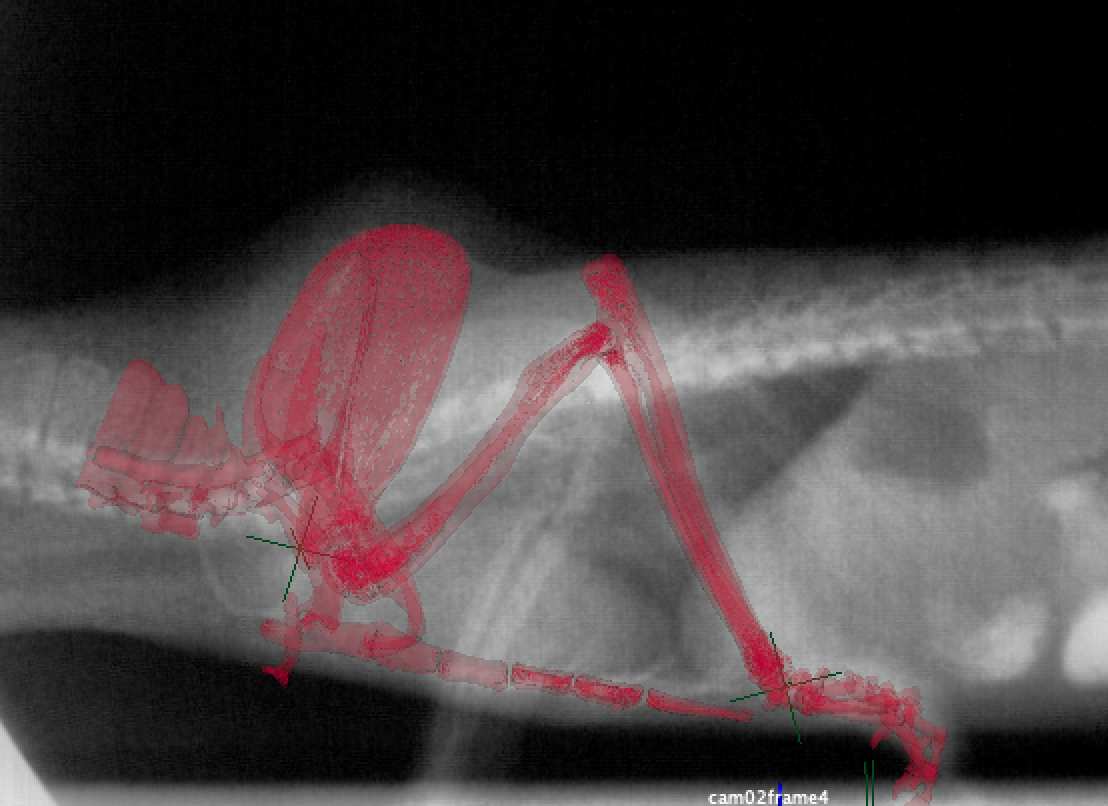
tegu all trials <30% too supinated
df_invivo_D[(df_invivo_D['glenoid.rx']>20)&(df_invivo_D['glenoid.ry']>40)][['percentage','individual','condition']].to_numpy()
df_invivo_S[(df_invivo_S['glenoid.rx']<-70)&(df_invivo_S['glenoid.ry']>0)][['percentage','individual','condition']].to_numpy()

### ROM envelopes: glenoid
rob's data cuts off at + - 90 degrees from neutral, which is 0,0,-20 for tegu and 0, -40, -80 for opossum

In [1715]:
viewYZ = (0,0)
viewXZ = (0,90)
viewXY = (90,90)
viewYX = (270,180)

view3Q = (45,45)
view3Qst = (-45,45)
view3Qsw = (135,45)

startView = viewXY

vX, vY = viewXY

maxrx, maxcrz, minrx, mincrz, maxry, minry, maxrz, minrz = glenoid_ranges.values()


plt.close('all')
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['grid.color'] = 'lightgrey'

dfS_robCrop = dfS.loc[(dfS['glenoid.rx'].between(-90,90))&(dfS['glenoid.ry'].between(-90,90))&(dfS['glenoid.rz'].between(-110,70))]
dfD_robCrop = dfD.loc[(dfD['glenoid.rx'].between(-90,90))&(dfD['glenoid.ry'].between(-130,50))&(dfD['glenoid.rz'].between(-170,10))]

fig = plt.figure(figsize=[8,12], constrained_layout=True)
ax0 = fig.add_subplot(321, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(322, projection='3d', proj_type = 'ortho')

ax2 = fig.add_subplot(323, projection='3d', proj_type = 'ortho')
ax3 = fig.add_subplot(324, projection='3d', proj_type = 'ortho')
ax4 = fig.add_subplot(325, projection='3d', proj_type = 'ortho')
ax5 = fig.add_subplot(326, projection='3d', proj_type = 'ortho')

format3dPlot(ax0, 'Tegu', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewYZ)
format3dPlot(ax1, 'Opossum', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewYZ)

format3dPlot(ax2, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXY)
format3dPlot(ax3, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXY)
format3dPlot(ax4, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXZ)
format3dPlot(ax5, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXZ)


addCosGrid(ax0, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)




alphaVertShoulder_S,alphaEdgeShoulder_S,alphaTriShoulder_S = alpha_shape_3D(dfS.loc[:,['glenoid.rx','glenoid.ry','glenoid.crz']].to_numpy(),20)
alphaVertShoulder_D,alphaEdgeShoulder_D,alphaTriShoulder_D = alpha_shape_3D(dfD.loc[:,['glenoid.rx','glenoid.ry','glenoid.crz']].to_numpy(),20)

ax0.plot_trisurf(dfS['glenoid.rx'],dfS['glenoid.ry'],alphaTriShoulder_S,dfS['glenoid.crz'], shade=True, cmap='YlGnBu',linewidth=0, antialiased=True)
ax1.plot_trisurf(dfD['glenoid.rx'],dfD['glenoid.ry'],alphaTriShoulder_D,dfD['glenoid.crz'], shade=True, cmap='YlOrRd', linewidth=0, antialiased=True)

ax2.plot_trisurf(dfS['glenoid.rx'],dfS['glenoid.ry'],alphaTriShoulder_S,dfS['glenoid.crz'], shade=True, cmap='YlGnBu',linewidth=0, antialiased=True)
ax3.plot_trisurf(dfD['glenoid.rx'],dfD['glenoid.ry'],alphaTriShoulder_D,dfD['glenoid.crz'], shade=True, cmap='YlOrRd', linewidth=0, antialiased=True)
ax4.plot_trisurf(dfS['glenoid.rx'],dfS['glenoid.ry'],alphaTriShoulder_S,dfS['glenoid.crz'], shade=True, cmap='YlGnBu',linewidth=0, antialiased=True)
ax5.plot_trisurf(dfD['glenoid.rx'],dfD['glenoid.ry'],alphaTriShoulder_D,dfD['glenoid.crz'], shade=True, cmap='YlOrRd', linewidth=0, antialiased=True)


ax0.scatter(dfS['glenoid.rx'],dfS['glenoid.ry'],dfS['glenoid.crz'], s=0.5, c='#3CA9A6', depthshade=True, zorder=4, alpha=.25)
ax1.scatter(dfD['glenoid.rx'],dfD['glenoid.ry'],dfD['glenoid.crz'], s=0.5, c='#FFCA4E', depthshade=True, zorder=4, alpha=.25)



ax2.scatter(dfS['glenoid.rx'],dfS['glenoid.ry'],dfS['glenoid.crz'], s=0.5, c='#3CA9A6', depthshade=True, zorder=4, alpha=.25)
ax3.scatter(dfD['glenoid.rx'],dfD['glenoid.ry'],dfD['glenoid.crz'], s=0.5, c='#FFCA4E', depthshade=True, zorder=4, alpha=.25)
ax4.scatter(dfS['glenoid.rx'],dfS['glenoid.ry'],dfS['glenoid.crz'], s=0.5, c='#3CA9A6', depthshade=True, zorder=4, alpha=.25)
ax5.scatter(dfD['glenoid.rx'],dfD['glenoid.ry'],dfD['glenoid.crz'], s=0.5, c='#FFCA4E', depthshade=True, zorder=4, alpha=.25)
connection1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

# def animate(i):
#     ax0.view_init(elev=45, azim=i/10)
#     ax1.view_init(elev=45, azim=i/10)
#     return fig

# both_ani = animation.FuncAnimation(fig, animate, 
#                                frames=3600, interval=5, blit=True)

# plt.show()

# plt.savefig('both3Q.png', dpi=150, transparent=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [1720]:
viewYZ = (0,0)
viewXZ = (0,90)
viewXY = (90,90)
viewYX = (270,180)

view3Q = (45,45)
view3Qst = (-45,45)
view3Qsw = (135,45)

startView = viewXY

vX, vY = viewXY

maxrx, maxcrz, minrx, mincrz, maxry, minry, maxrz, minrz = elbow_ranges.values()


plt.close('all')
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['grid.color'] = 'lightgrey'

dfS_robCrop = dfS.loc[(dfS['elbow.rx'].between(-90,90))&(dfS['elbow.ry'].between(-90,90))&(dfS['elbow.rz'].between(-110,70))]
dfD_robCrop = dfD.loc[(dfD['elbow.rx'].between(-90,90))&(dfD['elbow.ry'].between(-130,50))&(dfD['elbow.rz'].between(-170,10))]

fig = plt.figure(figsize=[8,12], constrained_layout=True)
ax0 = fig.add_subplot(321, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(322, projection='3d', proj_type = 'ortho')

ax2 = fig.add_subplot(323, projection='3d', proj_type = 'ortho')
ax3 = fig.add_subplot(324, projection='3d', proj_type = 'ortho')
ax4 = fig.add_subplot(325, projection='3d', proj_type = 'ortho')
ax5 = fig.add_subplot(326, projection='3d', proj_type = 'ortho')

format3dPlot(ax0, 'Tegu', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewYZ)
format3dPlot(ax1, 'Opossum', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewYZ)

format3dPlot(ax2, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXY)
format3dPlot(ax3, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXY)
format3dPlot(ax4, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXZ)
format3dPlot(ax5, '', (minrx, maxrx), (minry, maxry), (mincrz, maxcrz), view=viewXZ)


addCosGrid(ax0, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minrx,maxrx), (minry,maxry), (minrz,maxrz), 5, xLevels=1, color='grey', linewidths=0.1)




alphaVertShoulder_S,alphaEdgeShoulder_S,alphaTriShoulder_S = alpha_shape_3D(dfS.loc[:,['elbow.rx','elbow.ry','elbow.crz']].to_numpy(),20)
alphaVertShoulder_D,alphaEdgeShoulder_D,alphaTriShoulder_D = alpha_shape_3D(dfD.loc[:,['elbow.rx','elbow.ry','elbow.crz']].to_numpy(),20)

ax0.plot_trisurf(dfS['elbow.rx'],dfS['elbow.ry'],alphaTriShoulder_S,dfS['elbow.crz'], shade=True, cmap='YlGnBu',linewidth=0, antialiased=True)
ax1.plot_trisurf(dfD['elbow.rx'],dfD['elbow.ry'],alphaTriShoulder_D,dfD['elbow.crz'], shade=True, cmap='YlOrRd', linewidth=0, antialiased=True)

ax2.plot_trisurf(dfS['elbow.rx'],dfS['elbow.ry'],alphaTriShoulder_S,dfS['elbow.crz'], shade=True, cmap='YlGnBu',linewidth=0, antialiased=True)
ax3.plot_trisurf(dfD['elbow.rx'],dfD['elbow.ry'],alphaTriShoulder_D,dfD['elbow.crz'], shade=True, cmap='YlOrRd', linewidth=0, antialiased=True)
ax4.plot_trisurf(dfS['elbow.rx'],dfS['elbow.ry'],alphaTriShoulder_S,dfS['elbow.crz'], shade=True, cmap='YlGnBu',linewidth=0, antialiased=True)
ax5.plot_trisurf(dfD['elbow.rx'],dfD['elbow.ry'],alphaTriShoulder_D,dfD['elbow.crz'], shade=True, cmap='YlOrRd', linewidth=0, antialiased=True)


ax0.scatter(dfS['elbow.rx'],dfS['elbow.ry'],dfS['elbow.crz'], s=0.5, c='#3CA9A6', depthshade=True, zorder=4, alpha=.25)
ax1.scatter(dfD['elbow.rx'],dfD['elbow.ry'],dfD['elbow.crz'], s=0.5, c='#FFCA4E', depthshade=True, zorder=4, alpha=.25)



ax2.scatter(dfS['elbow.rx'],dfS['elbow.ry'],dfS['elbow.crz'], s=0.5, c='#3CA9A6', depthshade=True, zorder=4, alpha=.25)
ax3.scatter(dfD['elbow.rx'],dfD['elbow.ry'],dfD['elbow.crz'], s=0.5, c='#FFCA4E', depthshade=True, zorder=4, alpha=.25)
ax4.scatter(dfS['elbow.rx'],dfS['elbow.ry'],dfS['elbow.crz'], s=0.5, c='#3CA9A6', depthshade=True, zorder=4, alpha=.25)
ax5.scatter(dfD['elbow.rx'],dfD['elbow.ry'],dfD['elbow.crz'], s=0.5, c='#FFCA4E', depthshade=True, zorder=4, alpha=.25)
connection1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

# def animate(i):
#     ax0.view_init(elev=45, azim=i/10)
#     ax1.view_init(elev=45, azim=i/10)
#     return fig

# both_ani = animation.FuncAnimation(fig, animate, 
#                                frames=3600, interval=5, blit=True)

# plt.show()

# plt.savefig('both3Q.png', dpi=150, transparent=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### R shit here

In [1112]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from rpy2.robjects.lib.dplyr import DataFrame
from rpy2.robjects import rl

alphashape3d = importr('alphashape3d')
tidyverse = importr('tidyverse')
ro.r('''
        getCriticalAlpha <- function(components, alphas){
          criticalIndex <- 1
          for (i in 1:length(components)){
            comp = as.numeric(components[[i]])
            if (any(comp != 1)){
              criticalIndex <- i
            }
          }
          criticalIndex <- criticalIndex + 1
          print(alphas[[criticalIndex]])
          return(list(criticalIndex, alphas[[criticalIndex]]))
        }
        ''')
getCriticalAlpha = ro.r['getCriticalAlpha']
with localconverter(ro.default_converter + pandas2ri.converter):
    rdf_S_glenoid = ro.r['as.matrix'](ro.conversion.py2rpy(dfS[['glenoid.rx','glenoid.ry','glenoid.crz']].copy()))
    rdf_D_glenoid = ro.r['as.matrix'](ro.conversion.py2rpy(dfD[['glenoid.rx','glenoid.ry','glenoid.crz']].copy()))
    rdf_S_elbow = ro.r['as.matrix'](ro.conversion.py2rpy(dfS[['elbow.rx','elbow.ry','elbow.crz']].copy()))
    rdf_D_elbow = ro.r['as.matrix'](ro.conversion.py2rpy(dfD[['elbow.rx','elbow.ry','elbow.crz']].copy()))
#     rdf_S_model = ro.r['as.matrix'](ro.conversion.py2rpy(df_M_S[['Rx','Ry','cRz']].copy()))
#     rdf_D_model = ro.r['as.matrix'](ro.conversion.py2rpy(df_M_D[['Rx','Ry','cRz']].copy()))
    
subTenAlphas = np.linspace(0.1,9.9, 99)
supTenAlphas = np.linspace(10, 100, 91)
alphas = np.concatenate((subTenAlphas,supTenAlphas))
alphaCols = [str(round(alpha,3)).replace('.','_') for alpha in alphas]


alphas_sens = np.arange(1,101)
alphaCols_sens = [str(round(alpha,3)).replace('.','_') for alpha in alphas_sens]


def getAlphaObjects(rdf, alphas):
    try:
        alphaCols = [str(round(alpha,3)).replace('.','_') for alpha in alphas]
        print("...calculating alphas...")
        alphaShapes = alphashape3d.ashape3d(rdf, alphas, pert=True)
        print("...calculating components...")
        components = alphashape3d.components_ashape3d(alphaShapes, indexAlpha="all")
        print("...calculating volumes...")
        volumes = alphashape3d.volume_ashape3d(alphaShapes, indexAlpha="all")
    #     print("...calculating normals...")
    #     normals = alphashape3d.surfaceNormals(alphaShapes, indexAlpha="all")
        print("...calculating critical alpha...")
        [crit_index, crit_val] = getCriticalAlpha(components, alphas)
        shapes = np.array(alphaShapes, dtype=object)
        tetras_df = pd.DataFrame(alphaShapes[0]).rename(columns={**{0:'index1',1:'index2',2:'index3',3:'index4',4:'intervals'},**dict(zip(range(5,len(alphas)+5),alphaCols))})
        triangles_df = pd.DataFrame(alphaShapes[1]).rename(columns={**{0:'index1',1:'index2',2:'index3',3:'on_convex_hull',4:'attached',5:'intervals1',6:'intervals2',7:'intervals3'},**dict(zip(range(8,len(alphas)+8),alphaCols))})
        edges_df = pd.DataFrame(alphaShapes[2]).rename(columns={**{0:'index1',1:'index2',2:'on_convex_hull',3:'attached',4:'intervals1',5:'intervals2',6:'intervals3'},**dict(zip(range(7,len(alphas)+7),alphaCols))})
        vertices_df = pd.DataFrame(alphaShapes[3]).rename(columns={**{0:'index',1:'on_convex_hull',2:'intervals1',3:'intervals2'},**dict(zip(range(4,len(alphas)+4),alphaCols))})
        vertices_df['x'],vertices_df['y'],vertices_df['z'] = alphaShapes[4].T[0],alphaShapes[4].T[1],alphaShapes[4].T[2]
        components_df = pd.DataFrame(np.array(components, dtype=object).T).rename(columns=dict(zip(range(0,len(alphas)+1),alphaCols)))
        volumes_df = pd.DataFrame(np.array(volumes, dtype=object)).transpose().rename(columns=dict(zip(range(0,len(alphas)+1),alphaCols)))
    #     normals_df = pd.DataFrame(np.array(normals, dtype=object), columns=['normal','center'], index=alphaCols)
        return {'tetrahedrons':tetras_df, 'triangles': triangles_df, 'edges': edges_df, 'vertices': vertices_df,
                'components': components_df, 'volumes': volumes_df, 'crit_val':crit_val, 'crit_index':crit_index }
    except rpy2.rinterface_lib.embedded.RRuntimeError:
        return {}

# alpha_s_glenoid = getAlphaObjects(rdf_S_glenoid, alphas_sens)
# alpha_d_glenoid = getAlphaObjects(rdf_D_glenoid, alphas_sens)
# alpha_s_elbow = getAlphaObjects(rdf_S_elbow, alphas_sens)
# alpha_d_elbow = getAlphaObjects(rdf_D_elbow, alphas_sens)

# %pip install kneed
from kneed import DataGenerator, KneeLocator

def autoAlphaChooser(dfs_with_volumes, names, starting_alpha, sParam=10.0, curve='concave', direction='increasing'):
    volumes_df = pd.concat(dfs_with_volumes, axis=1).astype('float')
    volumes_df.columns=names
    alphas = [float(alphaCol.replace('_','.')) for alphaCol in volumes_df.index]
    maxVol = volumes_df.iloc[-1].max()
    minVol = volumes_df.iloc[-1].min()
    volumes_df.set_index(pd.Index(alphas), inplace=True)
    volumes_df.rename(columns={"index":"alpha"}, inplace=True)
    maxCol = volumes_df.columns[list(volumes_df.iloc[-1].values).index(maxVol)]
    minCol = volumes_df.columns[list(volumes_df.iloc[-1].values).index(minVol)]
    ratio = maxCol+' : '+minCol
    volumes_df[ratio] = np.divide(volumes_df.loc[:,maxCol],volumes_df.loc[:,minCol])
    volumes_df[ratio].fillna(0, inplace=True)
    ratio_series = volumes_df.loc[starting_alpha:,ratio].copy() if starting_alpha else volumes_df.loc[:,ratio].copy()
    kneedle = KneeLocator(list(ratio_series.index), ratio_series, S=sParam, curve=curve, direction=direction)
    return([volumes_df, kneedle])
    
plt.close("all")
volumes_df, auto_alpha = autoAlphaChooser([alpha_s_glenoid['volumes'].T,alpha_d_glenoid['volumes'].T,alpha_s_elbow['volumes'].T,alpha_d_elbow['volumes'].T],['Tegu glenoid','Opossum glenoid','Tegu elbow','Opossum elbow'],15, 10.0, 'convex', 'decreasing')
fig, ax = plt.subplots()
volumes_df.loc[:,['Tegu glenoid','Opossum glenoid','Tegu elbow','Opossum elbow']].plot(ax=ax, color=['C0','C1','#A0CBE8','#F1CE63'])
volumes_df.loc[:,[volumes_df.columns[-1]]].plot(secondary_y=True, style='g',ax=ax)
# ax.vlines(auto_alpha.knee, volumes_df.min().min(), volumes_df.max().max(), color='r', label='knee')
# auto_alpha.knee

ax.vlines(20, 0, maxMax, color='red')
ax.annotate(text='20', xy =(((20-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='center',size=8)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-1112-9792392a7f62>:108: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s='20', xy =(((20-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='center',size=8)


Text(0.21992653810835627, 1.01, '20')

### Downsampling

In [906]:
def downsample(df, species, factor=1, random=False):
    full = df.loc[df.species == species].copy()
    full.loc[:,'uid'] = full.index
    full.loc[:,'animalside'] = full.animal+full.side
    if random:
        frames_to_pick = np.sort(np.random.choice(list(full.index), len(full)//factor, replace=False))
        return(full.loc[frames_to_pick])
    for animalside in full.animalside.unique():
        as_df = full[full.animalside == animalside]
        min_frame, max_frame = as_df.frame.min(), as_df.frame.max()
        candidate_range = np.arange(min_frame, max_frame+1)
        frames_to_pick = list(candidate_range[::int(factor)])
        full.drop(full[(full['animalside']==animalside)&(~full['frame'].isin(frames_to_pick))].index, inplace=True)
    return(full)

factors_to_test = np.arange(1,11)
df_S_1to10 = [downsample(df, 'Tegu', factor) for factor in factors_to_test]
df_D_1to10 = [downsample(df, 'Opossum', factor) for factor in factors_to_test]

df_S_1to10_rand = [downsample(df, 'Tegu', factor, random=True) for factor in factors_to_test]
df_D_1to10_rand = [downsample(df, 'Opossum', factor, random=True) for factor in factors_to_test]

In [907]:
with localconverter(ro.default_converter + pandas2ri.converter):
    rdf_S_glenoid_1to10 = [ro.r['as.matrix'](ro.conversion.py2rpy(dfS[['glenoid.rx','glenoid.ry','glenoid.crz']].copy())) for dfS in df_S_1to10]
    rdf_D_glenoid_1to10 = [ro.r['as.matrix'](ro.conversion.py2rpy(dfD[['glenoid.rx','glenoid.ry','glenoid.crz']].copy())) for dfD in df_D_1to10]
    rdf_S_glenoid_1to10_rand = [ro.r['as.matrix'](ro.conversion.py2rpy(dfS[['glenoid.rx','glenoid.ry','glenoid.crz']].copy())) for dfS in df_S_1to10_rand]
    rdf_D_glenoid_1to10_rand = [ro.r['as.matrix'](ro.conversion.py2rpy(dfD[['glenoid.rx','glenoid.ry','glenoid.crz']].copy())) for dfD in df_D_1to10_rand]

# alphas_S_1to10 = [getAlphaObjects(rdf_S_glenoid, alphas_sens) for rdf_S_glenoid in rdf_S_glenoid_1to10]
# alphas_D_1to10 = [getAlphaObjects(rdf_D_glenoid, alphas_sens) for rdf_D_glenoid in rdf_D_glenoid_1to10]
alphas_S_1to10_rand = [getAlphaObjects(rdf_S_glenoid_rand, alphas_sens) for rdf_S_glenoid_rand in rdf_S_glenoid_1to10_rand]
alphas_D_1to10_rand = [getAlphaObjects(rdf_D_glenoid_rand, alphas_sens) for rdf_D_glenoid_rand in rdf_D_glenoid_1to10_rand]



import csv
# for i, alphaobj in enumerate(alphas_S_1to10):
#     name = 'alpha_S_'+str(i)
#     with open('./alphas/'+name+'.csv', 'w') as f:
#         for key in alphaobj.keys():
#             f.write("%s,%s\n"%(key,alphaobj[key]))
# for i, alphaobj in enumerate(alphas_D_1to10):
#     name = 'alpha_D_'+str(i)
#     with open('./alphas/'+name+'.csv', 'w') as f:
#         for key in alphaobj.keys():
#             f.write("%s,%s\n"%(key,alphaobj[key]))
for i, alphaobj in enumerate(alphas_S_1to10_rand):
    name = 'alpha_S_rand_'+str(i)
    with open('./alphas/'+name+'.csv', 'w') as f:
        for key in alphaobj.keys():
            f.write("%s,%s\n"%(key,alphaobj[key]))
for i, alphaobj in enumerate(alphas_D_1to10_rand):
    name = 'alpha_D_rand_'+str(i)
    with open('./alphas/'+name+'.csv', 'w') as f:
        for key in alphaobj.keys():
            f.write("%s,%s\n"%(key,alphaobj[key]))

...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 8
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 9
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 9
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 13
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 13
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 17
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 16


R[write to console]: Error in if (dim(edges)[1] > 0) for (ij in 1:dim(edges)[1]) { : 
  argument is of length zero



...calculating alphas...
...calculating components...
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 16


R[write to console]: Error in if (dim(edges)[1] > 0) for (ij in 1:dim(edges)[1]) { : 
  argument is of length zero



...calculating alphas...
...calculating components...
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 9
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 9
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 13
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 10
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 11
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 10
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alpha...
[1] 11
...calculating alphas...
...calculating components...
...calculating volumes...
...calculating critical alph

In [913]:
volumes_df

,Tegu uniform 1/8,Opossum uniform 1/8,Tegu random 1/8,Opossum random 1/8,Tegu uniform 1/8_to_Opossum uniform 1/8_ratio
1.0,0.000000e+00,36.618028,0.000000e+00,36.618028,0.000000
2.0,2.329233e+01,4344.098849,2.329233e+01,4344.098849,0.005362
3.0,6.085419e+02,37720.885072,6.085419e+02,37720.885072,0.016133
4.0,6.576324e+03,101462.505204,6.576324e+03,101462.505204,0.064815
5.0,3.045203e+04,160973.638924,3.045203e+04,160973.638924,0.189174
...,...,...,...,...,...
96.0,1.184677e+06,561166.438427,1.184677e+06,561166.438427,2.111097
97.0,1.184900e+06,564278.221829,1.184900e+06,564278.221829,2.099851
98.0,1.191012e+06,564389.706232,1.191012e+06,564389.706232,2.110266
99.0,1.191027e+06,564586.650458,1.191027e+06,564586.650458,2.109555


In [1106]:
plt.close("all")
fig, ax = plt.subplots(3,2, sharey='all', figsize=[15,12])

volumes_df, auto_alpha = autoAlphaChooser([alphas_S_1to10[0]['volumes'].T,alphas_D_1to10[0]['volumes'].T],['Tegu uniform 1/8','Opossum uniform 1/8'],18, 10.0, 'convex', 'decreasing')
volumes_df.loc[:,['Tegu uniform 1/8','Opossum uniform 1/8']].plot(ax=ax[0,0])
volumes_df.loc[:,[volumes_df.columns[-1]]].plot(secondary_y=True, style='g',ax=ax[0,0])
ax[0,0].vlines(auto_alpha.knee, volumes_df.min().min(), volumes_df.max().max(), color='r')
ax[0,0].title.set_text('1 in 8 (no further downsampling)')
x_bounds = ax[0,0].get_xlim()
ax[0,0].legend(fontsize=10)
ax[0,0].annotate(text=int(auto_alpha.knee), xy =(((auto_alpha.knee-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='center',size=8)

yMax = [volumes_df.max().max()]

for v_i, a_i, denom in zip(np.arange(1,6),[(0,1),(1,0),(1,1),(2,0),(2,1)],((np.arange(5)+2)*8).astype('str')):
    volumes_df, auto_alpha = autoAlphaChooser([alphas_S_1to10[v_i]['volumes'].T,alphas_D_1to10[v_i]['volumes'].T],['Tegu uniform 1/'+denom,'Opossum uniform 1/'+denom],18, 10.0, 'convex', 'decreasing')
    volumes_df_rand, auto_alpha_rand = autoAlphaChooser([alphas_S_1to10_rand[v_i]['volumes'].T,alphas_D_1to10_rand[v_i]['volumes'].T],['Tegu random 1/'+denom,'Opossum random 1/'+denom],18, 10.0, 'convex', 'decreasing')
    volumes_df.loc[:,['Tegu uniform 1/'+denom,'Opossum uniform 1/'+denom]].plot(ax=ax[a_i], color=['C0','C1'])
    volumes_df_rand.loc[:,['Tegu random 1/'+denom,'Opossum random 1/'+denom]].plot(ax=ax[a_i], color=['#1852CC','#E84A00'])
    volumes_df.loc[:,[volumes_df.columns[-1]]].plot(secondary_y=True, style='g',ax=ax[a_i])
    volumes_df_rand.loc[:,[volumes_df_rand.columns[-1]]].plot(secondary_y=True, style='#0D2913',ax=ax[a_i])
    x_bounds = ax[a_i].get_xlim()
    ax[a_i].legend(fontsize=10)
    ax[a_i].title.set_text('1 in '+denom)
    yMax.append(volumes_df.max().max())

maxMax = max(yMax)
ax[0,1].vlines(22, 0, maxMax, color='r')
ax[0,1].annotate(text='U,R 22', xy =(((22-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='center',size=8)

ax[1,0].vlines(24, 0, maxMax, color='r')
ax[1,0].vlines(26, 0, maxMax, color='#781408')
ax[1,0].annotate(text='U 24', xy =(((24-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='right',size=8)
ax[1,0].annotate(text='R 26', xy =(((26-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = '#781408', horizontalalignment='left',size=8)

ax[1,1].vlines(26, 0, maxMax, color='r')
ax[1,1].vlines(28, 0, maxMax, color='#781408')
ax[1,1].annotate(text='U 26', xy =(((26-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='right',size=8)
ax[1,1].annotate(text='R 28', xy =(((28-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = '#781408', horizontalalignment='left',size=8)

ax[2,0].vlines(27, 0, maxMax, color='r')
ax[2,0].vlines(30, 0, maxMax, color='#781408')
ax[2,0].annotate(text='U 27', xy =(((27-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='right',size=8)
ax[2,0].annotate(text='R 30', xy =(((30-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = '#781408', horizontalalignment='left',size=8)

ax[2,1].vlines(30, 0, maxMax, color='r')
ax[2,1].vlines(37, 0, maxMax, color='#781408')
ax[2,1].annotate(text='U 30', xy =(((30-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='right',size=8)
ax[2,1].annotate(text='R 37', xy =(((37-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = '#781408', horizontalalignment='left',size=8)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-1106-55040787f1b1>:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0,0].annotate(s=int(auto_alpha.knee), xy =(((auto_alpha.knee-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='center',size=8)
<ipython-input-1106-55040787f1b1>:29: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0,1].annotate(s='U,R 22', xy =(((22-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01), xycoords='axes fraction', c = 'red', horizontalalignment='center',size=8)
<ipython-input-1106-55040787f1b1>:33: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[1,0].an

Text(0.3760330578512397, 1.01, 'R 37')

## automate choosing alpha

In [109]:
volumes_df = alpha_d['volumes'].T.join(alpha_s['volumes'].T, lsuffix='opossum', rsuffix='tegu').replace(0, np.nan)
volumes_df.index = pd.to_numeric([index.replace('_','.') for index in volumes_df.index])
volumes_df.columns=['opossum','tegu']
volumes_df['t-o ratio'] = volumes_df['tegu']/volumes_df['opossum']
volumes_df['ratio d1'] = np.gradient(volumes_df['t-o ratio'])
zero_crossings = [volumes_df.index[index] for index in np.where(np.diff(np.sign(volumes_df['ratio d1'])))[0]]
zero_crossing_rows = volumes_df.loc[zero_crossings].loc[(volumes_df['tegu'] >= volumes_df['tegu'].max()/2)&(volumes_df['opossum'] >= volumes_df['opossum'].max()/2)]
first_zero_crossing_row = zero_crossing_rows.iloc[0]
second_zero_crossing_row = zero_crossing_rows.iloc[1]



fig, ax = plt.subplots()
volumes_df.loc[:,['opossum','tegu']].plot(ax=ax, style=['blue','orange'])
volumes_df.loc[:,['t-o ratio']].plot(secondary_y=True, style='g',ax=ax, label='tegu-opossum ratio')
# volumes_df.loc[:,['ratio d1']].plot(secondary_y=True, style='g',ax=ax)
ax.vlines(second_zero_crossing_row.name, volumes_df.min().min(), volumes_df.max().max(), color='r', label='second 0 crossing of ratio d1')
ax.vlines(allEnclosed_d, volumes_df.min().min(), volumes_df.max().max(), color='blue', linestyle=':', label='opossum critical')
ax.vlines(allEnclosed_s, volumes_df.min().min(), volumes_df.max().max(), color='orange', linestyle=':', label='tegu critical')
ax.vlines(waterTight_d, volumes_df.min().min(), volumes_df.max().max(), color='blue', linestyle='dashed', label='opossum watertight')
ax.vlines(waterTight_s, volumes_df.min().min(), volumes_df.max().max(), color='orange', linestyle='dashed', label='tegu watertight')
ax.legend()

NameError: name 'alpha_d' is not defined

# SWAP CRX AND CRZ FOR ALL BELOW

In [220]:
#center and superimpose joint alpha shapes
def centerJoints(df, species):
    df = df[df['species']==species[0]].copy()
    RCols = [col for col in df.columns if re.match(r'(c*R[xyz])', col)]
    for col in RCols:
        df[col+'_centered'] = df[col]-df[col].mean()
    return df
    
salCentered = centerJoints(df, 's')
didCentered = centerJoints(df, 'd')

rotationsCentered = getRotationRanges(salCentered, didCentered)
CmaxRx, CmaxcRz, CminRx, CmincRz, CmaxRy, CminRy, CmaxRz, CminRz = rotationsCentered.values()

alpha = 25
alphaSalVert,alphaSalEdge, alphaSalTri = alpha_shape_3D(np.array([salCentered.cRz_centered,salCentered.Ry_centered,salCentered.Rz_centered]).T,alpha)
alphaDidVert,alphaDidEdge, alphaDidTri = alpha_shape_3D(np.array([didCentered.cRz_centered,didCentered.Ry_centered,didCentered.Rz_centered]).T,alpha)


plt.close('all')


fig = plt.figure(figsize=[15,10], constrained_layout=True)
ax0 = fig.add_subplot(121, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(122, projection='3d', proj_type = 'ortho')



format3dPlot(ax0, 'Tegu', (CmincRz, CmaxcRz), (CminRy, CmaxRy), (CminRz, CmaxRz), view3Q)
format3dPlot(ax1, 'Opossum', (CmincRz, CmaxcRz), (CminRy, CmaxRy), (CminRz, CmaxRz), view3Q)

addCosGrid(ax0, (CminRx,CmaxRx), (CminRy,CmaxRy), (CminRz,CmaxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (CminRx,CmaxRx), (CminRy,CmaxRy), (CminRz,CmaxRz), 5, xLevels=1, color='grey', linewidths=0.1)


ax0.plot_trisurf(salCentered.cRz_centered, salCentered.Ry_centered, alphaSalTri, salCentered.Rz_centered, shade=True, color=teguColor, linewidth=0, antialiased=True)
ax1.plot_trisurf(didCentered.cRz_centered, didCentered.Ry_centered, alphaDidTri, didCentered.Rz_centered, shade=True, color=opossumColor, linewidth=0, antialiased=True)

ax0.scatter(salCentered.cRz_centered,salCentered.Ry_centered,salCentered.Rz_centered, s=2, c=orangeYellowSeafoam[6], depthshade=False, edgecolors='None', alpha=0.95)
ax1.scatter(didCentered.cRz_centered,didCentered.Ry_centered,didCentered.Rz_centered, s=2, c=orangeYellowSeafoam[2], depthshade=False, edgecolors='None', alpha=0.95)


# ax0.add_patch(PolygonPatch(hullDXZ, fill=True, color='blue'))






connection1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

plt.show()
# plt.savefig('3q.png', dpi=150, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-150-96946a24d4af>:145: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  gridAx.plot_wireframe(xx, yy, czz, rcount = zSize/interval, ccount=ySize/interval, **kwargs)


AttributeError: 'Line3DCollection' object has no property 'zlevels'

In [9]:
scaled_Zma_cols = [col for col in scaled_t_ma_all_data.columns if col[-3:] == 'Zma']
colsForForr = scaled_Zma_cols
# dfSforCorr = dfS.filter(colsForForr)
# dfSforCorr = dfSforCorr.dropna(axis=1, how='all')
# corr = dfSforCorr.corr()
# corr.style.background_gradient(cmap='bwr')
dfDforCorr = dfD.filter(colsForForr)
dfDforCorr_colnames_raw = [col.split('_',1)[1].rsplit('_',1)[0] for col in colsForForr]
dfDforCorr.columns = dfDforCorr_colnames_raw
dfDforCorr = dfDforCorr.dropna(axis=1, how='all')
corr = dfDforCorr.corr()
corr.style.background_gradient(cmap='bwr')

,lat_cdl,lat_crn,pec_crn,pec_int,pec_cdl,trl,dsc,dac,bic,tmj
lat_cdl,1.000000,0.778650,-0.046383,0.248244,0.305269,0.478560,-0.451596,-0.175176,0.446266,0.743981
lat_crn,0.778650,1.000000,-0.113531,0.169180,0.261982,0.495467,-0.456976,-0.340188,0.161647,0.652616
pec_crn,-0.046383,-0.113531,1.000000,0.753182,0.545561,-0.460594,0.055906,-0.464617,0.322532,-0.111656
pec_int,0.248244,0.169180,0.753182,1.000000,0.928390,-0.261588,-0.315568,-0.767559,0.575061,0.078853
pec_cdl,0.305269,0.261982,0.545561,0.928390,1.000000,0.061553,-0.307862,-0.762522,0.551862,0.087666
trl,0.478560,0.495467,-0.460594,-0.261588,0.061553,1.000000,0.291802,0.396915,0.141848,nan
dsc,-0.451596,-0.456976,0.055906,-0.315568,-0.307862,0.291802,1.000000,0.542833,-0.206050,-0.269684
dac,-0.175176,-0.340188,-0.464617,-0.767559,-0.762522,0.396915,0.542833,1.000000,-0.408894,0.310535
bic,0.446266,0.161647,0.322532,0.575061,0.551862,0.141848,-0.206050,-0.408894,1.000000,0.079723
tmj,0.743981,0.652616,-0.111656,0.078853,0.087666,nan,-0.269684,0.310535,0.079723,1.000000


In [218]:
from scipy.spatial import Delaunay
import numpy as np
from collections import defaultdict

def alpha_shape_3D(pos, alpha):
    """
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """

    tetra = Delaunay(pos)
    # Find radius of the circumsphere.
    # By definition, radius of the sphere fitting inside the tetrahedral needs 
    # to be smaller than alpha value
    # http://mathworld.wolfram.com/Circumsphere.html
    tetrapos = np.take(pos,tetra.vertices,axis=0)
    normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
    ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
    a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
    Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
    Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
    Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
    c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
    r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))
    # Find tetrahedrals
    tetras = tetra.vertices[r<alpha,:]
    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)

    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    return Vertices,Edges,Triangles

In [51]:
dfD[(dfD['Rx']>0)&(dfD['Rx']<5)&(dfD['Ry']>45)&(dfD['Ry']<50)][['scaled_dac_Xma','scaled_dac_Yma','scaled_dac_Zma']]

,scaled_dac_Xma,scaled_dac_Yma,scaled_dac_Zma
3691,-0.011453,0.009194,-0.005271
5168,-0.011008,0.010386,-0.005277


In [34]:
#color by momentarm

def RgbMa(df, species, muscleName, xPos=True, yPos=True, zPos=True, normalizeAcrossSpecies=True):
    df = df.copy()
    dfspecies = df.filter(items=['species'])
    if not normalizeAcrossSpecies: 
        df = df[df['species']==species[0]]
    df = df.filter(like=muscleName)
    df = df.replace(np.NaN, 0)
    Xma = df.filter(like='Xma')
    Yma = df.filter(like='Yma')
    Zma = df.filter(like='Zma')
    df['posXma'] = np.where(Xma > 0, Xma, 0)
    df['posYma'] = np.where(Yma > 0, Yma, 0)
    df['posZma'] = np.where(Zma > 0, Zma, 0)
    df['negXma'] = np.where(Xma < 0, abs(Xma), 0)
    df['negYma'] = np.where(Yma < 0, abs(Yma), 0)
    df['negZma'] = np.where(Zma < 0, abs(Zma), 0)
    df=df.drop([Xma.columns[0],Yma.columns[0],Zma.columns[0]], axis=1)
    mmMax = df.max().max()
    df=df/mmMax
    df['Xma'] = df['posXma'] if xPos else df['negXma']
    df['Yma'] = df['posYma'] if yPos else df['negYma']
    df['Zma'] = df['posZma'] if zPos else df['negZma']
    totalXYZ = df[['Xma','Yma','Zma']].sum(axis=1)
    df['scale'] = preprocessing.MinMaxScaler().fit_transform(totalXYZ.values.reshape(-1, 1))
    if normalizeAcrossSpecies:
        df = dfspecies.join(df)
        df = df[df['species']==species[0]]
    return(df[['Xma','Yma','Zma','scale']])



# stanceS = RgbMa(df, 'salvator', 'scaled_dac', xPos=True, yPos=False, zPos=False, normalizeAcrossSpecies=True)
# stanceD = RgbMa(df, 'didelphis', 'scaled_dac', xPos=True, yPos=False, zPos=False, normalizeAcrossSpecies=True)
# swingS = RgbMa(df, 'salvator', 'scaled_dac', xPos=False, yPos=True, zPos=True, normalizeAcrossSpecies=True)
# swingD = RgbMa(df, 'didelphis', 'scaled_dac', xPos=False, yPos=True, zPos=True, normalizeAcrossSpecies=True)

stanceS = RgbMa(df, 'salvator', 'scaled_dac', xPos=True, yPos=True, zPos=True, normalizeAcrossSpecies=True)
stanceD = RgbMa(df, 'didelphis', 'scaled_dac', xPos=True, yPos=True, zPos=True, normalizeAcrossSpecies=True)
swingS = RgbMa(df, 'salvator', 'scaled_dac', xPos=False, yPos=False, zPos=False, normalizeAcrossSpecies=True)
swingD = RgbMa(df, 'didelphis', 'scaled_dac', xPos=False, yPos=False, zPos=False, normalizeAcrossSpecies=True)

plt.close('all')


fig = plt.figure(figsize=[12,12], constrained_layout=True)
ax0 = fig.add_subplot(221, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(222, projection='3d', proj_type = 'ortho')
ax2 = fig.add_subplot(223, projection='3d', proj_type = 'ortho')
ax3 = fig.add_subplot(224, projection='3d', proj_type = 'ortho')


# 'Tegu Stance R: Prn, G: Add, B: Ext'
# 'Opossum Stance R: Prn, G: Add, B: Ext'

format3dPlot(ax0, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXZ)
format3dPlot(ax1, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXZ)
format3dPlot(ax2, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXZ)
format3dPlot(ax3, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXZ)

addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)

ax0.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=stanceS['scale']*15, c=stanceS[['Xma','Yma','Zma']], vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax1.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=stanceD['scale']*15, c=stanceD[['Xma','Yma','Zma']], vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax2.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=swingS['scale']*15, c=swingS[['Xma','Yma','Zma']], vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax3.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=swingD['scale']*15, c=swingD[['Xma','Yma','Zma']], vmin=0, vmax=1, depthshade=False, edgecolors='None')

connection4 = fig.canvas.mpl_connect('motion_notify_event', on_move4)

plt.show()

#threshold, then pca?

# plt.savefig('dsc.png', dpi=150, transparent=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'mincRx' is not defined

In [9]:

def divergingMa(df, species, muscleName, normalizeAcrossSpecies=True):
    df = df.copy()
    dfspecies = df.filter(items=['species'])
    if not normalizeAcrossSpecies: 
        df = df[df['species']==species[0]]
    df = df.filter(like=muscleName)
    df = df.replace(np.NaN, 0)
    mmMax = df.max().max()
    mmAbsMax = abs(df).max().max()
    mmMin = df.min().min()
    mmAbsMin = abs(df).min().min()
    MaxMinMax = max((abs(mmMax),abs(mmMin)))
    def MinMaxScalerPrescribedRange(X, min_input, max_input, min_output=0, max_output=1):
        X_std = (X - min_input) / (max_input - min_input)
        X_scaled = X_std * (max_output - min_output) + min_output
        return X_scaled
    Xma = df.filter(like='Xma')/MaxMinMax   #maxabs scale across all 3 axes
    Yma = df.filter(like='Yma')/MaxMinMax
    Zma = df.filter(like='Zma')/MaxMinMax
    df['Xmag'] = abs(Xma)   #magnitude of moment arm
    df['Ymag'] = abs(Yma)
    df['Zmag'] = abs(Zma)
    df['Xscale'] = MinMaxScalerPrescribedRange(Xma, -1, 1)    #get color mapping var by normalizing moment arms to lie between 0 and 1 (with -1 and 1 as min and max input values)
    df['Yscale'] = MinMaxScalerPrescribedRange(Yma, -1, 1)
    df['Zscale'] = MinMaxScalerPrescribedRange(Zma, -1, 1)
    if normalizeAcrossSpecies:
        df = dfspecies.join(df)
        df = df[df['species']==species[0]]
    return(df)



pec_crn_S = divergingMa(df, 'salvator', 'scaled_dac', normalizeAcrossSpecies=True)
pec_crn_D = divergingMa(df, 'didelphis', 'scaled_dac', normalizeAcrossSpecies=True)

plt.close('all')


fig = plt.figure(figsize=[12,18], constrained_layout=True)
ax0 = fig.add_subplot(321, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(322, projection='3d', proj_type = 'ortho')
ax2 = fig.add_subplot(323, projection='3d', proj_type = 'ortho')
ax3 = fig.add_subplot(324, projection='3d', proj_type = 'ortho')
ax4 = fig.add_subplot(325, projection='3d', proj_type = 'ortho')
ax5 = fig.add_subplot(326, projection='3d', proj_type = 'ortho')


# 'Tegu Stance R: Prn, G: Add, B: Ext'
# 'Opossum Stance R: Prn, G: Add, B: Ext'

format3dPlot(ax0, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view3Q)
format3dPlot(ax1, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view3Q)
format3dPlot(ax2, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view3Q)
format3dPlot(ax3, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view3Q)
format3dPlot(ax4, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view3Q)
format3dPlot(ax5, '', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view3Q)

addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax4, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax5, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)

ax0.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=pec_crn_S['Xmag']*30, c=pec_crn_S['Xscale'], cmap='seismic', vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax1.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=pec_crn_D['Xmag']*30, c=pec_crn_D['Xscale'], cmap='seismic', vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax2.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=pec_crn_S['Ymag']*30, c=pec_crn_S['Yscale'], cmap='seismic', vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax3.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=pec_crn_D['Ymag']*30, c=pec_crn_D['Yscale'], cmap='seismic', vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax4.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=pec_crn_S['Zmag']*30, c=pec_crn_S['Zscale'], cmap='seismic', vmin=0, vmax=1, depthshade=False, edgecolors='None')
ax5.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=pec_crn_D['Zmag']*30, c=pec_crn_D['Zscale'], cmap='seismic', vmin=0, vmax=1, depthshade=False, edgecolors='None')

connection6 = fig.canvas.mpl_connect('motion_notify_event', on_move6)

plt.show()

# plt.savefig('dac_div_3Q.png', dpi=150, transparent=True)




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
#color by momentarm
dfRgb = df.copy()
dfSrgb = df[df['species']=='s']
dfDrgb = df[df['species']=='d']

scaled_muscle_cols = [col for col in dfRgb.columns if col.split('_')[0] == 'scaled' and col[-2:] == 'ma']
dfRgb[scaled_muscle_cols] = dfRgb[scaled_muscle_cols].replace(np.NaN, 0)

lat_crn = dfRgb[scaled_muscle_cols].iloc[:, 3:6]
latmax = lat_crn.max().max()
latmin = lat_crn.min().min()

latNewX = lat_crn.scaled_lat_crn_Xma+abs(latmin)
latNewY = lat_crn.scaled_lat_crn_Yma+abs(latmin)
latNewZ = lat_crn.scaled_lat_crn_Zma+abs(latmin)

latNewXnorm = latNewX/(latmax+abs(latmin))
latNewYnorm = latNewY/(latmax+abs(latmin))
latNewZnorm = latNewZ/(latmax+abs(latmin))



# scaler = sklearn.preprocessing.MinMaxScaler().fit(dfRgb[scaled_muscle_cols])
# dfRgb[scaled_muscle_cols] = scaler.transform(dfRgb[scaled_muscle_cols])
# DrgbXYZ = scaler.transform(dfDrgb[['scaled_Tx','scaled_Ty','scaled_Tz']])

# # SrgbXYZ = np.array([SrgbX, SrgbY, SrgbZ]).reshape(3,len(SrgbX)).T
# # DrgbXYZ = np.array([DrgbX, DrgbY, DrgbZ]).reshape(3,len(DrgbX)).T
plt.close('all')


fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(122, projection='3d', proj_type = 'ortho')

format3dPlot(ax0, 'Tegu', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXY)
format3dPlot(ax1, 'Opossum', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXY)

addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)

ax0.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=2, c='black', depthshade=False, edgecolors='None')
ax1.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=2, c='black', depthshade=False, edgecolors='None')
ax0.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=2, c=np.array([np.zeros(len(latNewXnorm)),latNewYnorm,np.zeros(len(latNewXnorm)),latNewXnorm]).T[dfSrgb.index], depthshade=False, edgecolors='None')
ax1.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=2, c=np.array([np.zeros(len(latNewXnorm)),latNewYnorm,np.zeros(len(latNewXnorm)),latNewXnorm]).T[dfDrgb.index], depthshade=False, edgecolors='None')

connection1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [132]:
 dfRgb[scaled_muscle_cols]

,scaled_lat_cdl_Xma,scaled_lat_cdl_Yma,scaled_lat_cdl_Zma,scaled_lat_crn_Xma,scaled_lat_crn_Yma,scaled_lat_crn_Zma,scaled_pec_crn_Xma,scaled_pec_crn_Yma,scaled_pec_crn_Zma,scaled_pec_int_Xma,...,scaled_dsc_Zma,scaled_dac_Xma,scaled_dac_Yma,scaled_dac_Zma,scaled_tmj_Xma,scaled_tmj_Yma,scaled_tmj_Zma,scaled_bic_Xma,scaled_bic_Yma,scaled_bic_Zma
0,0.012859,0.006960,-0.000229,0.022645,0.010314,-0.003437,-0.006570,-0.002715,-0.010182,-0.009046,...,-0.013349,-0.001171,0.017018,0.000238,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.012505,0.007474,0.000368,0.021933,0.010731,-0.003034,-0.005310,-0.004207,-0.009598,-0.006805,...,-0.013153,-0.001645,0.017111,0.000644,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.011591,0.007343,0.001136,0.020691,0.010317,-0.002525,-0.001301,-0.007083,-0.007018,0.000024,...,-0.012470,-0.004141,0.016628,0.000210,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.011346,0.006381,-0.005551,0.019934,0.007633,-0.014985,0.003120,-0.011373,-0.004881,0.006568,...,-0.009181,-0.005483,0.014815,0.001495,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.008757,0.004531,-0.006397,0.017222,0.006807,-0.016707,0.008865,-0.013984,-0.002230,0.015560,...,-0.008108,-0.007360,0.011620,0.001595,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,0.000000,0.000000,0.000000,0.012402,-0.022690,-0.002173,-0.000514,0.011865,0.008826,0.000000,...,-0.003891,-0.006769,0.008313,-0.000005,0.0,0.0,0.0,-0.007131,0.008228,0.012621
5029,0.000000,0.000000,0.000000,0.015883,-0.016479,0.003090,-0.001225,0.016797,0.012043,0.000000,...,0.000707,-0.008765,0.009636,0.002292,0.0,0.0,0.0,-0.012104,0.011546,0.011563
5030,0.000000,0.000000,0.000000,0.016061,-0.013051,0.009394,-0.001191,0.019642,0.013506,0.000000,...,0.003928,-0.010812,0.011501,0.003386,0.0,0.0,0.0,-0.012179,0.010731,0.008750
5031,0.000000,0.000000,0.000000,0.016148,-0.012392,0.011521,-0.000220,0.019816,0.013365,0.000000,...,0.004584,-0.012184,0.011221,0.003200,0.0,0.0,0.0,-0.007536,0.007560,0.006150


In [185]:
#color by translation
dfRgb = df.copy()
# dfSrgb = df[df['species']=='s']
# dfDrgb = df[df['species']=='d']

scaled_Ts = dfRgb[['scaled_Tx','scaled_Ty','scaled_Tz']]
tMin = scaled_Ts.min().min()
tMax = scaled_Ts.max().max()

scalerMinMax = preprocessing.MinMaxScaler((tMin,tMax)).fit(dfRgb[['scaled_Tx','scaled_Ty','scaled_Tz']])
dfRgbMinMax = scalerMinMax.transform(dfRgb[['scaled_Tx','scaled_Ty','scaled_Tz']])
scaler01 = preprocessing.MinMaxScaler((0,1)).fit(dfRgbMinMax)
dfRgb01 = scaler01.transform(dfRgbMinMax)

dfSrgb = dfRgb01[dfRgb[dfRgb['species']=='s'].index]
dfDrgb = dfRgb01[dfRgb[dfRgb['species']=='d'].index]


plt.close('all')


fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0 = fig.add_subplot(121, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(122, projection='3d', proj_type = 'ortho')

format3dPlot(ax0, 'Tegu', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXY)
format3dPlot(ax1, 'Opossum', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), viewXY)

addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)
addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, xLevels=1, color='grey', linewidths=0.1)

ax0.scatter(dfS.cRx,dfS.Ry,dfS.Rz, s=3, c=dfSrgb, depthshade=False, edgecolors='None')
ax1.scatter(dfD.cRx,dfD.Ry,dfD.Rz, s=3, c=dfDrgb, depthshade=False, edgecolors='None')

connection1 = fig.canvas.mpl_connect('motion_notify_event', on_move)

plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [165]:
sklearn.preprocessing

AttributeError: module 'sklearn' has no attribute 'preprocessing'

In [320]:
#PCA
from sklearn.decomposition import PCA

XYZ = df[['cRx','Ry','Rz']].to_numpy()
XYZ = sklearn.preprocessing.normalize(XYZ)
aPCA = PCA().fit(XYZ)

sXYZ = dfS[['cRx','Ry','Rz']].to_numpy()
sXYZ = sklearn.preprocessing.normalize(sXYZ)
sPCA = PCA().fit(sXYZ)

dXYZ = dfD[['cRx','Ry','Rz']].to_numpy()
dXYZ = sklearn.preprocessing.normalize(dXYZ)
dPCA = PCA().fit(dXYZ)


aPCAs = aPCA.transform(sXYZ).T
aPCAd = aPCA.transform(dXYZ).T
sPCAs = sPCA.transform(sXYZ).T
sPCAd = sPCA.transform(dXYZ).T
dPCAs = dPCA.transform(sXYZ).T
dPCAd = dPCA.transform(dXYZ).T

maxPC1a = max([max(aPCAs[0]),max(aPCAd[0])])
minPC1a = min([min(aPCAs[0]),min(aPCAd[0])])
maxPC2a = max([max(aPCAs[1]),max(aPCAd[1])])
minPC2a = min([min(aPCAs[1]),min(aPCAd[1])])
maxPC3a = max([max(aPCAs[2]),max(aPCAd[2])])
minPC3a = min([min(aPCAs[2]),min(aPCAd[2])])

maxPC1s = max([max(sPCAs[0]),max(sPCAd[0])])
minPC1s = min([min(sPCAs[0]),min(sPCAd[0])])
maxPC2s = max([max(sPCAs[1]),max(sPCAd[1])])
minPC2s = min([min(sPCAs[1]),min(sPCAd[1])])
maxPC3s = max([max(sPCAs[2]),max(sPCAd[2])])
minPC3s = min([min(sPCAs[2]),min(sPCAd[2])])

maxPC1d = max([max(dPCAs[0]),max(dPCAd[0])])
minPC1d = min([min(dPCAs[0]),min(dPCAd[0])])
maxPC2d = max([max(dPCAs[1]),max(dPCAd[1])])
minPC2d = min([min(dPCAs[1]),min(dPCAd[1])])
maxPC3d = max([max(dPCAs[2]),max(dPCAd[2])])
minPC3d = min([min(dPCAs[2]),min(dPCAd[2])])

plt.close('all')



fig = plt.figure(figsize=[12,5], constrained_layout=True)
ax0PCA = fig.add_subplot(121, projection='3d', proj_type = 'ortho')
ax1PCA = fig.add_subplot(122, projection='3d', proj_type = 'ortho')

format3dPlot(ax0PCA, 'Tegu', (minPC1a, maxPC1a), (minPC2a, maxPC2a), (minPC3a, maxPC3a), viewXY, mode='pca')
format3dPlot(ax1PCA, 'Opossum', (minPC1a, maxPC1a), (minPC2a, maxPC2a), (minPC3a, maxPC3a), viewXY, mode='pca')

ax0PCA.scatter(aPCAs[0],aPCAs[1],aPCAs[2], s=3, depthshade=True)
ax1PCA.scatter(aPCAd[0],aPCAd[1],aPCAd[2], s=3, depthshade=True)



plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
def alpha_shape(points, alpha, only_outer=True): #c/o "Harold" on stackoverflow
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n, 3) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the set already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                if (j, i) in edges:
                    edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic, id = indices of corner points of the tetrahedron
    print(tri.vertices.shape)
    for ia, ib, ic, id in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        pd = points[id]

        # Computing radius of tetrahedron Circumsphere
        # http://mathworld.wolfram.com/Circumsphere.html

        pa2 = np.dot(pa, pa)
        pb2 = np.dot(pb, pb)
        pc2 = np.dot(pc, pc)
        pd2 = np.dot(pd, pd)

        a = np.linalg.det(np.array([np.append(pa, 1), np.append(pb, 1), np.append(pc, 1), np.append(pd, 1)]))

        Dx = np.linalg.det(np.array([np.array([pa2, pa[1], pa[2], 1]),
                                     np.array([pb2, pb[1], pb[2], 1]),
                                     np.array([pc2, pc[1], pc[2], 1]),
                                     np.array([pd2, pd[1], pd[2], 1])]))

        Dy = - np.linalg.det(np.array([np.array([pa2, pa[0], pa[2], 1]),
                                       np.array([pb2, pb[0], pb[2], 1]),
                                       np.array([pc2, pc[0], pc[2], 1]),
                                       np.array([pd2, pd[0], pd[2], 1])]))

        Dz = np.linalg.det(np.array([np.array([pa2, pa[0], pa[1], 1]),
                                     np.array([pb2, pb[0], pb[1], 1]),
                                     np.array([pc2, pc[0], pc[1], 1]),
                                     np.array([pd2, pd[0], pd[1], 1])]))

        c = np.linalg.det(np.array([np.array([pa2, pa[0], pa[1], pa[2]]),
                                    np.array([pb2, pb[0], pb[1], pb[2]]),
                                    np.array([pc2, pc[0], pc[1], pc[2]]),
                                    np.array([pd2, pd[0], pd[1], pd[2]])]))

        circum_r = math.sqrt(math.pow(Dx, 2) + math.pow(Dy, 2) + math.pow(Dz, 2) - 4 * a * c) / (2 * abs(a))
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, id)
            add_edge(edges, id, ia)
            add_edge(edges, ia, ic)
            add_edge(edges, ib, id)
    return edges

## Deprecated
### other tests for alpha quality
#### check if all vertices are enclosed, returns same index as criticality test

In [239]:
def getVerticesForAlpha(vertices_df, alpha):
    alpha_vertices_df = vertices_df.copy().loc[vertices_df[alpha]<3]
    alpha_vertices_df['subindex'] = range(len(alpha_vertices_df))
    return alpha_vertices_df
def getTrianglesForAlpha(triangles_df, alpha):
    alpha_triangles_df = triangles_df.copy().loc[triangles_df[alpha]==2.0]
    alpha_triangles_df['subindex'] = range(len(alpha_triangles_df))
    return alpha_triangles_df
def getNeighborTriangles(alpha_triangles_df, triangle_index):
    alpha_triangle_vertices = list(alpha_triangles_df.loc[triangle_index][['index1','index2','index3']])
    other_alpha_triangles_df = alpha_triangles_df.drop(triangle_index)
    neighbor_triangles_df = other_alpha_triangles_df.loc[(other_alpha_triangles_df['index1'].isin(alpha_triangle_vertices))|(other_alpha_triangles_df['index2'].isin(alpha_triangle_vertices)|(other_alpha_triangles_df['index3'].isin(alpha_triangle_vertices)))]
    return neighbor_triangles_df

# allEnclosed_d = float([key for key in params_d if params_d[key]['allEnclosed']][0].replace('_','.'))
# allEnclosed_s = float([key for key in params_s if params_s[key]['allEnclosed']][0].replace('_','.'))
# waterTight_d = float([key for key in params_d if 'waterTight' in params_d[key].keys() and params_d[key]['waterTight']][0].replace('_','.'))
# waterTight_s = float([key for key in params_s if 'waterTight' in params_s[key].keys() and params_s[key]['waterTight']][0].replace('_','.'))

In [26]:
alpha_s_model


0,tetra,[[1.95000...
1,triang,[[1.00000...
2,edge,[[1.00000...
3,vertex,[[1.00000...
4,x,[[ ...
5,alpha,[28]
6,xpert,[[ ...


#### check watertightness

In [237]:
# %pip install trimesh
import trimesh
# trimesh.util.attach_to_log()

def getVertexFaceRepresentationForAlpha(alphaObject_df, alpha):
    verts = getVerticesForAlpha(alphaObject_df['vertices'],alpha)[['x','y','z','index','subindex']]
    triangles = getTrianglesForAlpha(alphaObject_df['triangles'],alpha)[['index1','index2','index3','subindex']]
    for i in triangles.index:
        for indexn in ['index1','index2','index3']:
            index_to_find = float(triangles.loc[i, indexn])
            triangles.loc[i, indexn] = int(verts.loc[verts['index']==index_to_find]['subindex'])
    return([np.array(verts[['x','y','z']]), np.array(triangles[['index1','index2','index3']], dtype='int')])
def paramsByAlpha(alphaObject_df, alphaCols):
    result = {}
    for alpha in alphaCols:
#         print('testing '+alpha)
        encloses_all_vertices = np.all(alphaObject_df['vertices'][alpha]<3.0)
        volume = alphaObject_df['volumes'][alpha]
        if encloses_all_vertices:
            verts, triangles = getVertexFaceRepresentationForAlpha(alphaObject_df, alpha)
            mesh = trimesh.Trimesh(vertices=verts, faces=triangles, process=True)
            waterTight = mesh.is_watertight
            euler_characteristic = mesh.euler_number
            result[alpha] = {'allEnclosed':encloses_all_vertices, 'volume': volume, 'waterTight':waterTight,'euler':euler_characteristic}
        else:
            result[alpha] = {'allEnclosed':encloses_all_vertices, 'volume': volume}
    return result

# params_d = paramsByAlpha(alpha_d, alphaCols)
# params_s = paramsByAlpha(alpha_s, alphaCols)